### Importing the necessary libraries

In [67]:
import numpy as np
import pandas as pd
import re
import os
import warnings

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import missingno as msno

from scipy.stats import chi2_contingency

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, RobustScaler

from sklearn.model_selection import train_test_split

from sklearn.model_selection import StratifiedKFold

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, fbeta_score

### Initial settings

In [68]:
matplotlib.rcParams["font.size"] = 10
matplotlib.rcParams["figure.figsize"] = (8,6)
matplotlib.rcParams["figure.facecolor"] = '#00000000'

sns.set_style("darkgrid")
sns.set(rc={
            "font.size":10,
            "axes.titlesize":10,
            "axes.labelsize":15},
             style="darkgrid",
            )
sns.set_theme(color_codes=True)

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

warnings.filterwarnings('ignore')

### Reading the Dataset

In [69]:
dataset_path = 'data\Dataset.csv'
data_dict_path = 'data\Data_Dictionary.csv'

df_raw = pd.read_csv(dataset_path)
df_info= pd.read_csv(data_dict_path)

In [70]:
df_info

,Variable,Description
0,ID,Client Loan application ID
1,Client_Income,Client Income in $
2,Car_Owned,Any Car owned by client before applying for the loan for another car (0 means No and 1 means otherwise)
3,Bike_Owned,Any bike owned by client (0 means No and 1 means otherwise)
4,Active_Loan,Any other active loan at the time of aplication of loan (0 means No and 1 means otherwise)
5,House_Own,Any house owned by client (0 means No and 1 means otherwise)
6,Child_Count,Number of children the client has
7,Credit_Amount,Credit amount of the loan in $
8,Loan_Annuity,Loan annuity in $
9,Accompany_Client,Who accompanied the client when client applied for the loan


In [71]:
df_raw.sample(10)

,ID,Client_Income,Car_Owned,Bike_Owned,Active_Loan,House_Own,Child_Count,Credit_Amount,Loan_Annuity,Accompany_Client,Client_Income_Type,Client_Education,Client_Marital_Status,Client_Gender,Loan_Contract_Type,Client_Housing_Type,Population_Region_Relative,Age_Days,Employed_Days,Registration_Days,ID_Days,Own_House_Age,Mobile_Tag,Homephone_Tag,Workphone_Working,Client_Occupation,Client_Family_Members,Cleint_City_Rating,Application_Process_Day,Application_Process_Hour,Client_Permanent_Match_Tag,Client_Contact_Work_Tag,Type_Organization,Score_Source_1,Score_Source_2,Score_Source_3,Social_Circle_Default,Phone_Change,Credit_Bureau,Default
117888,12178951,27000,1.0,1.0,0.0,0.0,0.0,157500,4331.25,Alone,Service,Graduation,NaN,Female,CL,Home,0.022625,12444.0,5553.0,6451.0,4577.0,2.0,1,1,0,Core,2.0,2.0,1.0,10.0,Yes,Yes,Police,0.668028,0.640751,0.538863,0.3876,2481.0,1.0,0
110908,12119074,10800,0.0,0.0,0.0,1.0,0.0,52863.3,2341.35,Alone,Retired,Secondary,M,Male,CL,Home,0.018029,23037,365243,1080,4621,NaN,1,0,0,NaN,2.0,3.0,5.0,7.0,Yes,Yes,XNA,NaN,0.585110,0.643026,0.0761,643.0,2.0,0
42967,12111074,18000,0.0,0.0,0.0,1.0,0.0,45450,2550.6,Alone,Service,Secondary,M,Male,CL,Home,0.006207,15631,3331,8757,4024,NaN,1,0,0,Laborers,2.0,2.0,3.0,16.0,Yes,Yes,Business Entity Type 3,NaN,0.550323,NaN,NaN,2667.0,4.0,0
19500,12150322,9000,0.0,0.0,NaN,1.0,NaN,22500.0,2318.4,Alone,Retired,Secondary,M,Male,CL,Home,0.028663,24566,365243,2162,4930,NaN,1,0,0,NaN,2.0,2.0,3.0,11.0,Yes,Yes,XNA,NaN,0.479163,NaN,0.2876,1535.0,NaN,0
105266,12161203,22500,1.0,1.0,1.0,1.0,0.0,220500.0,5829.75,Relative,NaN,Secondary,M,Male,CL,NaN,0.026392,18052,NaN,2401,1603,5.0,1,0,1,Drivers,2.0,2.0,3.0,NaN,Yes,Yes,Construction,NaN,0.669556,0.656158,0.1237,1650.0,1.0,0
3500,12147250,15750,0.0,0.0,0.0,0.0,2.0,25200,2686.95,Alone,Service,Secondary,D,Female,CL,Rental,0.018209,16407,384,4469,4176,NaN,1,0,0,Managers,3.0,3.0,1.0,NaN,Yes,Yes,Business Entity Type 3,0.263099,0.497930,0.186293,NaN,235.0,2.0,0
118957,12129483,15750,0.0,0.0,NaN,0.0,0.0,107820,3165.3,Alone,Service,Secondary,S,Male,CL,Home,NaN,10282.0,3181.0,3917.0,2909.0,NaN,1,1,0,Sales,1.0,3.0,1.0,14.0,Yes,No,Self-employed,NaN,NaN,0.331251,NaN,2790.0,0.0,1
2830,12217575,NaN,1.0,1.0,1.0,1.0,1.0,35532,4229.55,Alone,Service,Secondary,M,Female,CL,Home,0.032561,10546,900,5756,3215,3.0,1,0,0,Drivers,3.0,1.0,4.0,15.0,Yes,Yes,Business Entity Type 3,NaN,0.489430,NaN,NaN,354.0,NaN,1
20718,12179746,NaN,0.0,0.0,1.0,1.0,0.0,116672.4,3424.5,Alone,Service,Secondary,M,Male,CL,Shared,0.005313,19591,849,5757,3132,NaN,1,0,1,Cooking,2.0,2.0,5.0,14.0,Yes,Yes,Kindergarten,NaN,0.662709,0.572682505,0.0722,2245.0,2.0,0
73284,12164223,13500,0.0,0.0,0.0,1.0,0.0,24767.55,2680.2,Alone,Retired,Secondary,M,Female,CL,Home,0.008625,22358,365243,10540,4547,NaN,1,0,0,NaN,2.0,2.0,3.0,12.0,Yes,Yes,XNA,NaN,0.519705,NaN,0.0742,427.0,1.0,0


In [72]:
df_raw.shape

(121856, 40)

### Checking the duplicate Values

In [73]:
df_raw.duplicated().sum()

0

#### `Observations`
There are no duplicate values 

### EDA and Data Preprocessing

<Axes: >

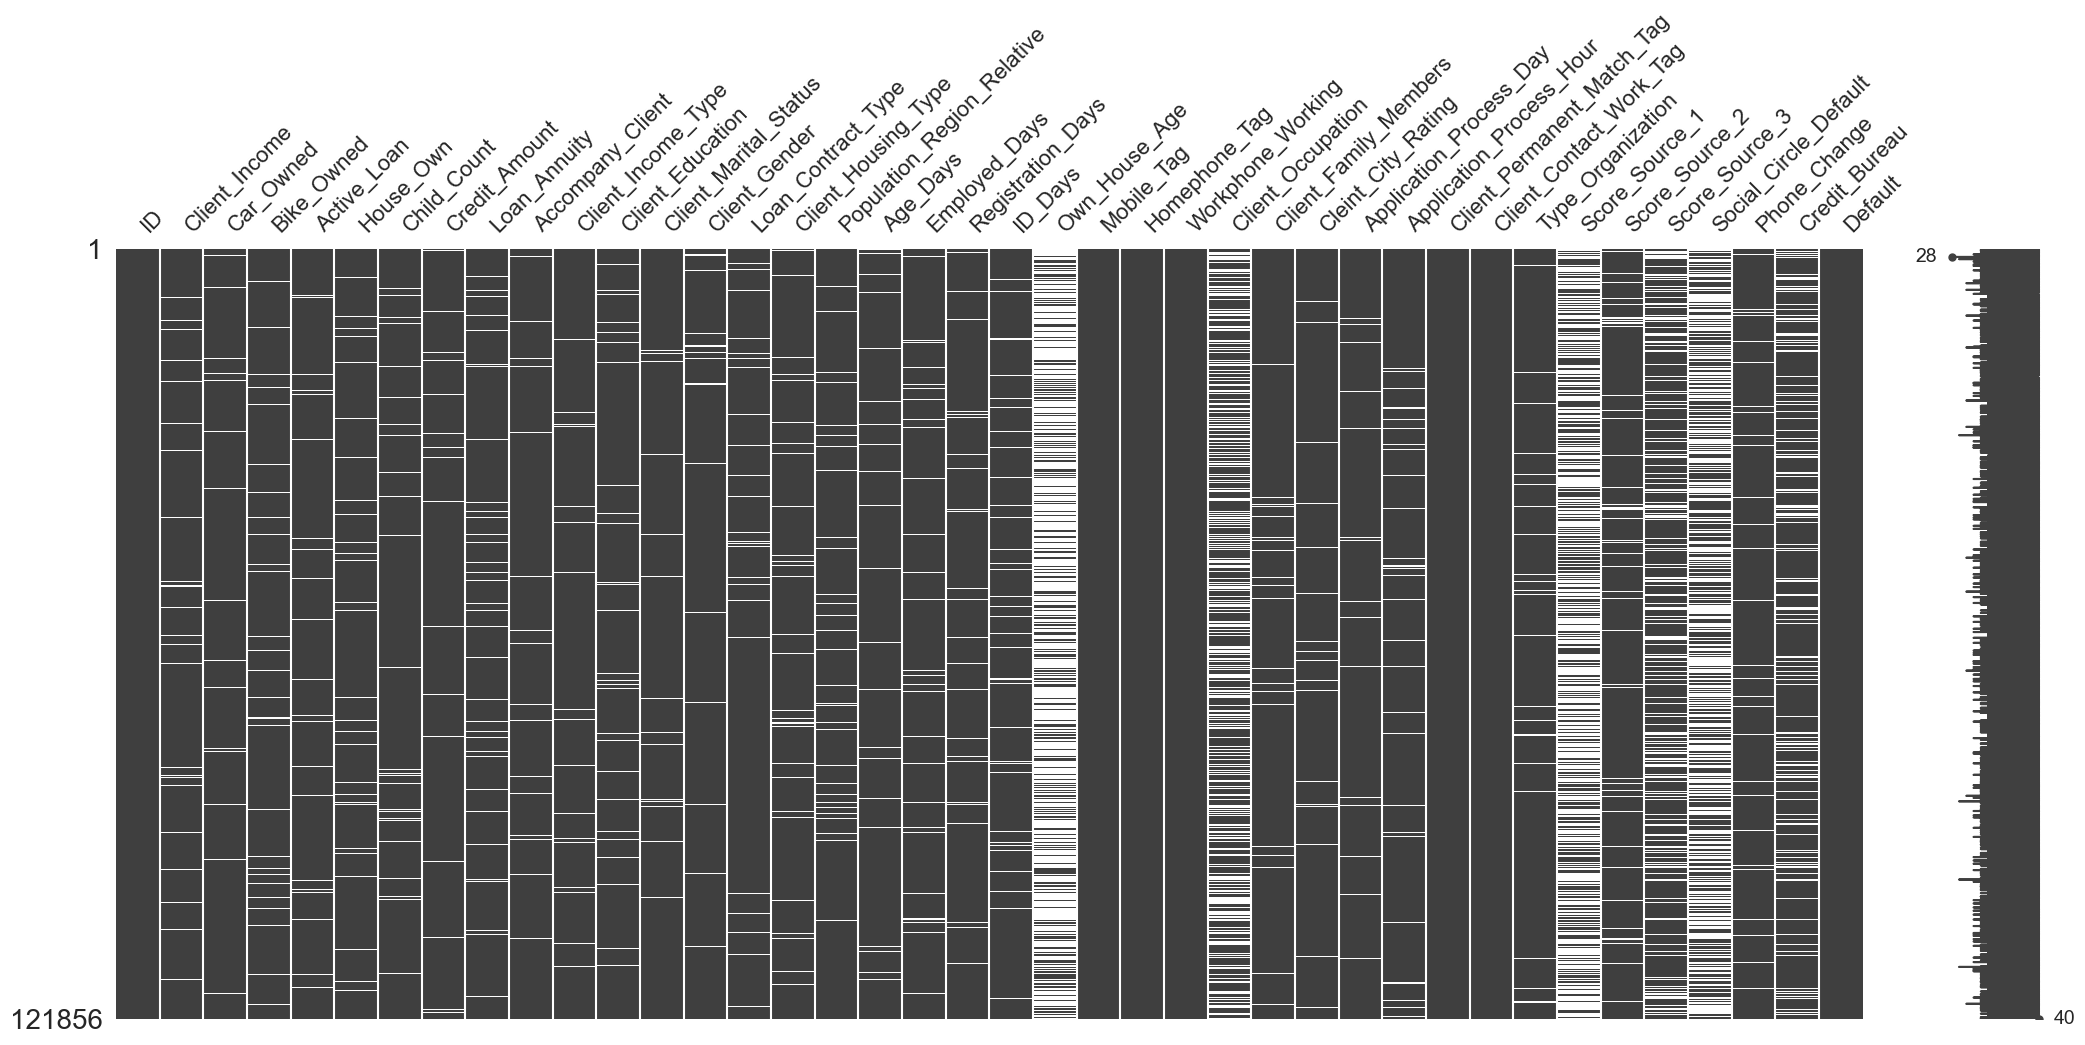

In [74]:
msno.matrix(df_raw)


### Percentage of null values 

In [75]:
null_df = (df_raw.isnull().sum()).sort_values(ascending=False).to_frame()
null_df.columns = ["No of Null values"]
null_df["% of Null values"] = round(null_df["No of Null values"]/len(df_raw)*100, 2)
null_df[null_df["No of Null values"] > 0]

,No of Null values,% of Null values
Own_House_Age,80095,65.73
Score_Source_1,68835,56.49
Social_Circle_Default,61928,50.82
Client_Occupation,41435,34.00
Score_Source_3,26921,22.09
Credit_Bureau,18540,15.21
ID_Days,5968,4.90
Score_Source_2,5686,4.67
Population_Region_Relative,4857,3.99
Loan_Annuity,4812,3.95


### `Observations`
- Almost all the variables except ID, some client variables, phone variables and Default have missing values

In [76]:
df_raw.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ID,121856.0,1.216093e+07,35176.941538,1.210000e+07,1.213046e+07,1.216093e+07,1.219139e+07,1.222186e+07
Car_Owned,118275.0,3.428535e-01,0.474665,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
Bike_Owned,118232.0,3.322620e-01,0.471026,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
Active_Loan,118221.0,4.991753e-01,0.500001,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
House_Own,118195.0,6.920597e-01,0.461644,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
Child_Count,118218.0,4.177790e-01,0.728802,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.900000e+01
Own_House_Age,41761.0,1.215732e+01,12.056079,0.000000e+00,5.000000e+00,9.000000e+00,1.500000e+01,6.900000e+01
Mobile_Tag,121856.0,9.999918e-01,0.002865,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
Homephone_Tag,121856.0,2.004989e-01,0.400375,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
Workphone_Working,121856.0,2.812008e-01,0.449587,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00


In [77]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121856 entries, 0 to 121855
Data columns (total 40 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   ID                          121856 non-null  int64  
 1   Client_Income               118249 non-null  object 
 2   Car_Owned                   118275 non-null  float64
 3   Bike_Owned                  118232 non-null  float64
 4   Active_Loan                 118221 non-null  float64
 5   House_Own                   118195 non-null  float64
 6   Child_Count                 118218 non-null  float64
 7   Credit_Amount               118224 non-null  object 
 8   Loan_Annuity                117044 non-null  object 
 9   Accompany_Client            120110 non-null  object 
 10  Client_Income_Type          118155 non-null  object 
 11  Client_Education            118211 non-null  object 
 12  Client_Marital_Status       118383 non-null  object 
 13  Client_Gender 

### Drop the unnessary Columns

In [78]:
df_raw.drop(columns = ['ID', 'Application_Process_Day', 'Application_Process_Hour', 'Accompany_Client'], inplace=True)

#### Analysis of Target Variable `Default`

In [79]:
df_raw["Default"].value_counts()

Default
0    112011
1      9845
Name: count, dtype: int64

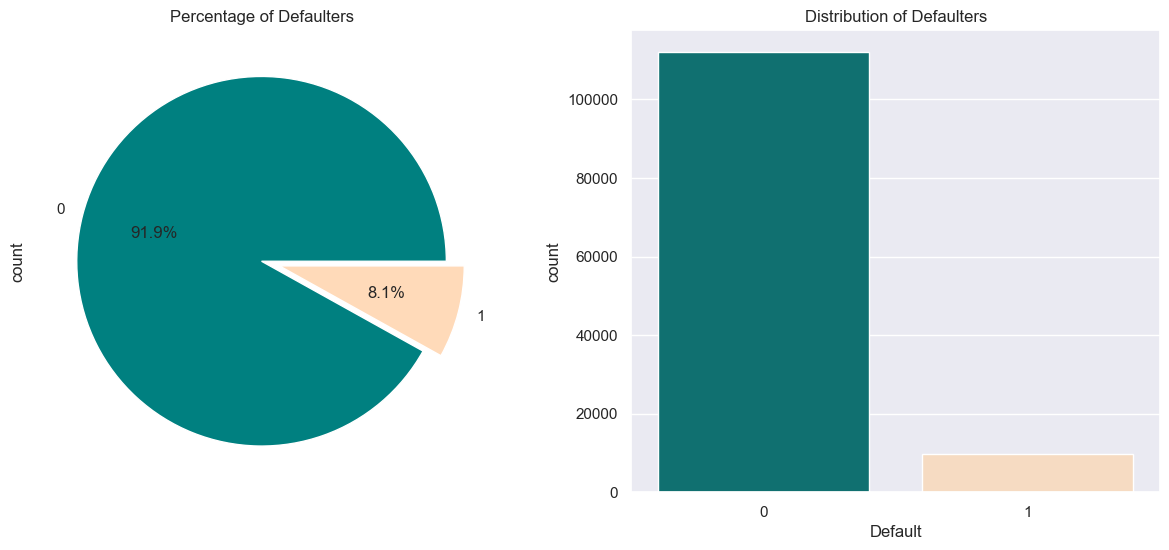

In [80]:
colors = ['#008080', '#FFDAB9']
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
df_raw['Default'].value_counts().plot.pie(explode=[0, 0.1], colors=colors, autopct='%1.1f%%', ax=ax1)
ax1.set_title('Percentage of Defaulters')
sns.countplot(x='Default', data=df_raw, ax=ax2, palette=colors)
ax2.set_title('Distribution of Defaulters')

plt.show()

#### `Observations`
- 1 : Defaulter
- 0 : Non Defaulters
- The **dataset** is highly **imbalanced**

#### Checking unique values of all the columns

In [81]:
def display_unique_values(df):
    for i, column in enumerate(df.columns):
        unique_values = df[column].unique()
        num_unique = len(unique_values)

        if num_unique > 10:
            unique_display = list(unique_values[:4]) + ['...'] + list(unique_values[-4:])
        else:
            unique_display = list(unique_values)

        print(f"{i+1}.  {column}")
        print(f"--> {df[column].dtypes}")
        print(f"--> {num_unique}")
        print(f"--> {unique_display}")
        print("\n")

display_unique_values(df_raw)

1.  Client_Income
--> object
--> 1517
--> ['6750', '20250', '18000', '15750', '...', '23557.5', '13140', '9764.1', '12840.75']


2.  Car_Owned
--> float64
--> 3
--> [0.0, 1.0, nan]


3.  Bike_Owned
--> float64
--> 3
--> [0.0, 1.0, nan]


4.  Active_Loan
--> float64
--> 3
--> [1.0, 0.0, nan]


5.  House_Own
--> float64
--> 3
--> [0.0, nan, 1.0]


6.  Child_Count
--> float64
--> 15
--> [0.0, 1.0, 2.0, nan, '...', 19.0, 12.0, 14.0, 9.0]


7.  Credit_Amount
--> object
--> 6817
--> ['61190.55', '15282', '59527.35', '53870.4', '...', '38522.25', '89138.7', '88885.8', '135534.6']


8.  Loan_Annuity
--> object
--> 16681
--> ['3416.85', '1826.55', '2788.2', '2295.45', '...', 3550.5, 1736.55, 3388.05, 2989.35]


9.  Client_Income_Type
--> object
--> 9
--> ['Commercial', 'Service', 'Retired', 'Govt Job', nan, 'Student', 'Unemployed', 'Maternity leave', 'Businessman']


10.  Client_Education
--> object
--> 6
--> ['Secondary', 'Graduation', 'Graduation dropout', nan, 'Junior secondary', 'Post Grad'

#### `Observations`
- There are some **numeric columns** that are **represented as object columns**

### Converting categorical variables to their original form
- All of the **potential_categorical_columns** can be considered as **categorical columns** (1 being Yes and 0 being No)

In [82]:
potential_categorical_columns = ['Car_Owned', 'Bike_Owned', 'Active_Loan', 'House_Own', 'Mobile_Tag', 'Homephone_Tag', 'Workphone_Working', 'Default']

for col in potential_categorical_columns:
    print(f"Value counts for {col}:")
    print(df_raw[col].value_counts())
    print("\n")

Value counts for Car_Owned:
Car_Owned
0.0    77724
1.0    40551
Name: count, dtype: int64


Value counts for Bike_Owned:
Bike_Owned
0.0    78948
1.0    39284
Name: count, dtype: int64


Value counts for Active_Loan:
Active_Loan
0.0    59208
1.0    59013
Name: count, dtype: int64


Value counts for House_Own:
House_Own
1.0    81798
0.0    36397
Name: count, dtype: int64


Value counts for Mobile_Tag:
Mobile_Tag
1    121855
0         1
Name: count, dtype: int64


Value counts for Homephone_Tag:
Homephone_Tag
0    97424
1    24432
Name: count, dtype: int64


Value counts for Workphone_Working:
Workphone_Working
0    87590
1    34266
Name: count, dtype: int64


Value counts for Default:
Default
0    112011
1      9845
Name: count, dtype: int64




#### `Observations`:
- The `Mobile_Tag` column can be dropped since it contains only one record with a value of 0, while the rest of the records have a value of 1

In [83]:
df_raw.drop(columns='Mobile_Tag', inplace=True)

### Checking numeric variables that are defined as 'object' type

In [84]:
potential_numerical_columns = ['Client_Income', 'Credit_Amount', 'Loan_Annuity', 'Population_Region_Relative', 'Age_Days', 'Employed_Days', 'Registration_Days', 'ID_Days', 'Score_Source_3']

numeric_issues = {}

for col in potential_numerical_columns:
    try:
        df_raw[col].astype(float)
    except ValueError as e:
        numeric_issues[col] = str(e)

numeric_issues

{'Client_Income': "could not convert string to float: '$'",
 'Credit_Amount': "could not convert string to float: '$'",
 'Loan_Annuity': "could not convert string to float: '$'",
 'Population_Region_Relative': "could not convert string to float: '@'",
 'Age_Days': "could not convert string to float: 'x'",
 'Employed_Days': "could not convert string to float: 'x'",
 'Registration_Days': "could not convert string to float: 'x'",
 'ID_Days': "could not convert string to float: 'x'",
 'Score_Source_3': "could not convert string to float: '&'"}

### Repalace unwanted Characters

In [85]:
def replace_unwanted_chars(value):
    if isinstance(value, str):
        return re.sub(r'[$@&]', '', value)
    return value

df_raw = df_raw.applymap(replace_unwanted_chars)

### Converting numeric features to numeric datatype

In [86]:
potential_numerical_columns = ['Client_Income', 'Credit_Amount', 'Loan_Annuity', 'Population_Region_Relative', 'Age_Days', 'Employed_Days', 'Registration_Days', 'ID_Days', 'Score_Source_3']

for col in potential_numerical_columns:
    df_raw[col] = pd.to_numeric(df_raw[col], errors='coerce')

### Converting features having 1 and 0 to categorical variables (Yes and No)

In [87]:
potential_categorical_columns = ['Car_Owned', 'Bike_Owned', 'Active_Loan', 'House_Own', 'Homephone_Tag', 'Workphone_Working']

for col in potential_categorical_columns:
    df_raw[col] = df_raw[col].replace({1: 'Yes', 0: 'No'})

### Loan Annuity by Default and Credit Amount by Default

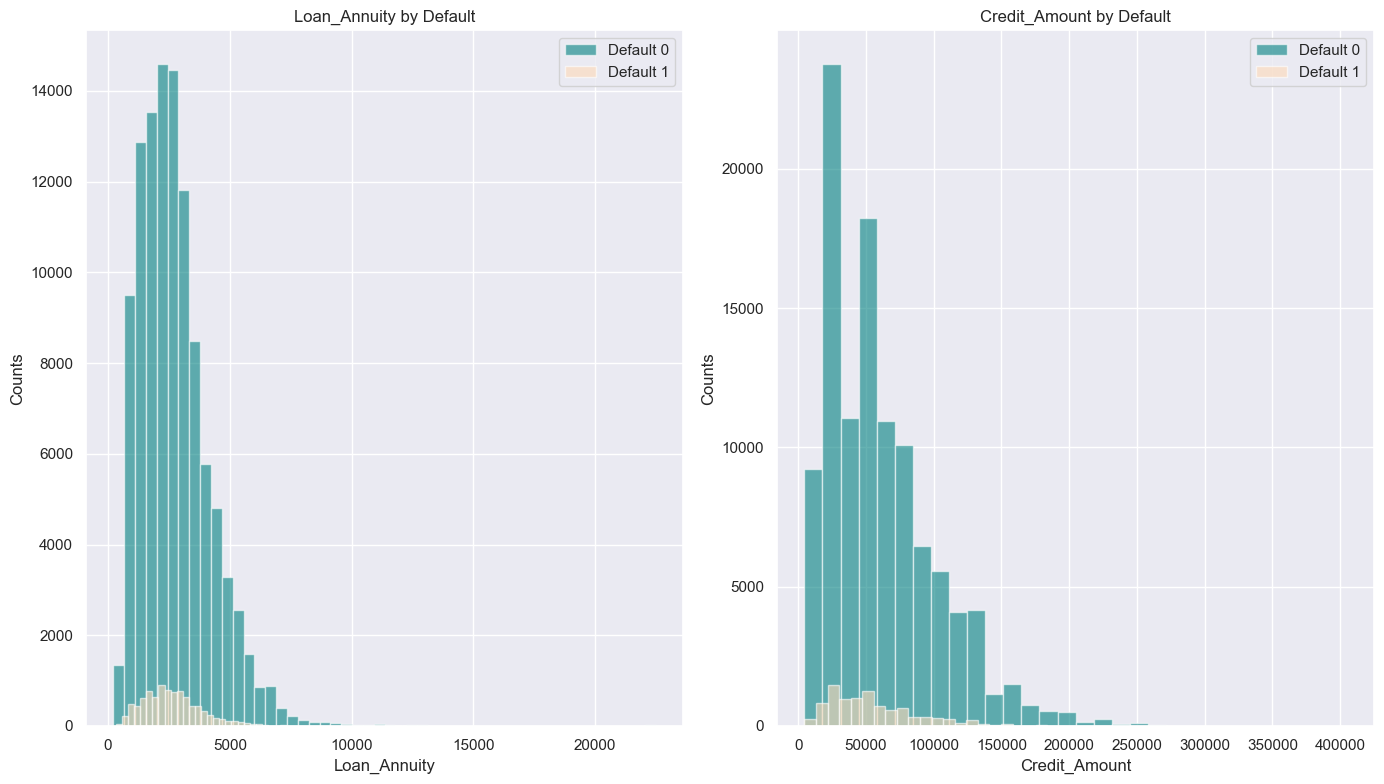

In [88]:
colors = {0: '#008080', 1: '#FFDAB9'}

fig, axes = plt.subplots(1, 2, figsize=(14, 8))

for label, group in df_raw.groupby('Default'):
    axes[0].hist(group['Loan_Annuity'], bins=50, alpha=0.6, label=f'Default {label}', color=colors[label])
axes[0].set_title("Loan_Annuity by Default")
axes[0].set_xlabel('Loan_Annuity')
axes[0].set_ylabel('Counts')
axes[0].legend(loc='upper right')

for label, group in df_raw.groupby('Default'):
    axes[1].hist(group['Credit_Amount'], bins=30, alpha=0.6, label=f'Default {label}', color=colors[label])
axes[1].set_title("Credit_Amount by Default")
axes[1].set_xlabel('Credit_Amount')
axes[1].set_ylabel('Counts')
axes[1].legend(loc='upper right')

plt.tight_layout()
plt.show()

#### `Observations`
- Both the graphs are right tailed, showing the presence of a few clients having higher amount of Loan Annuity and Credit Amount
- Most of the clients have Loan Annuity between 0 and 5000
- Most of the clients have Credit Amount between 0 and 100000

### Client Income Type by Loan Annuity( Installment payments- EMI)

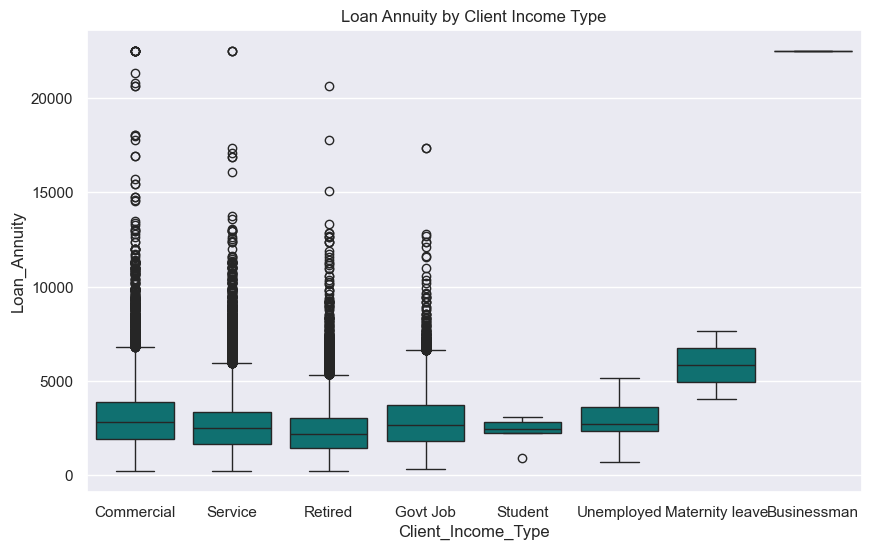

In [89]:
colors = ['#008080']

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_raw, x='Client_Income_Type', y='Loan_Annuity', palette=colors)
plt.title('Loan Annuity by Client Income Type')
plt.show()

#### `Observations`
- Clients having Income from Commercial, Retired, Govt Job and Service sectors tend to have a larger Loan Annuity(EMI)

### Distribution of Client Income Type

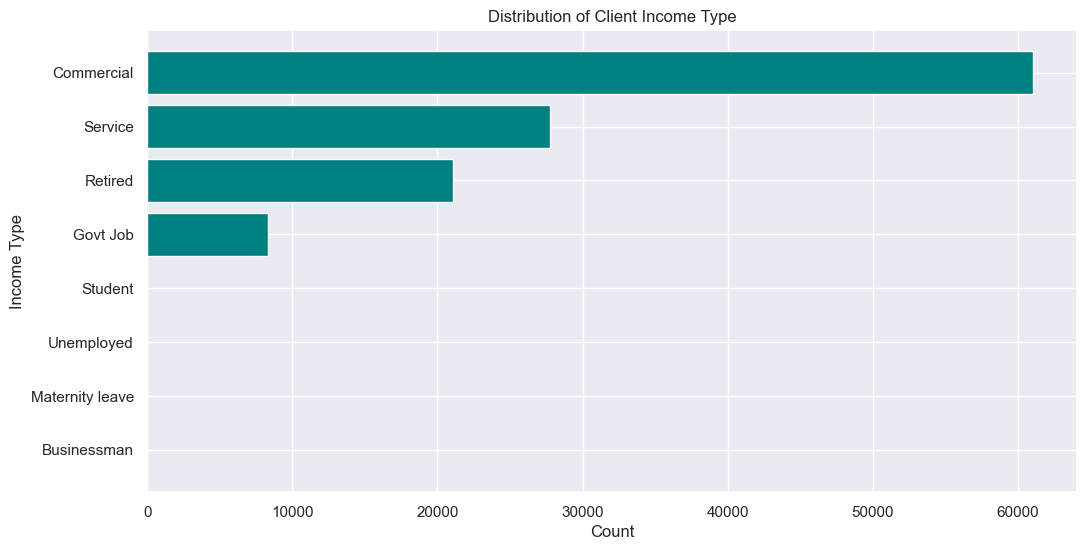

In [90]:
# Filter out missing values in the 'Client_Income_Type' column
temp_df = df_raw[df_raw['Client_Income_Type'].notna()]

unique_income_types = temp_df['Client_Income_Type'].unique()
income_type_counts = temp_df['Client_Income_Type'].value_counts()

plt.figure(figsize=(12, 6))
plt.barh(unique_income_types, income_type_counts, color='#008080')  # Teal color
plt.gca().invert_yaxis()

plt.xlabel('Count')
plt.ylabel('Income Type')
plt.title('Distribution of Client Income Type')

plt.show()

#### `Observations`
- Majority of the clients belong to the Commercial and Service sectors, with Commercial being the largest category

- There are very few clients in categories like Student, Retired, Maternity leave, and Businessman

- Clients with Government jobs have a moderate presence, significantly higher than the least represented categories but much lower than Commercial and Service sectors

- Given the low representation of categories such as Student, Unemployed, Maternity leave, and Businessman, it's best to combine these into one category called "Other"

### Modifying the infrequent categories of Client Income Type

In [91]:
def map_income_type(category):
    if category in ['Student', 'Unemployed', 'Maternity leave', 'Businessman']:
        return 'Other'
    else:
        return category
    
df_raw['Client_Income_Type'] = df_raw['Client_Income_Type'].apply(map_income_type)

### Client Income Type by Default

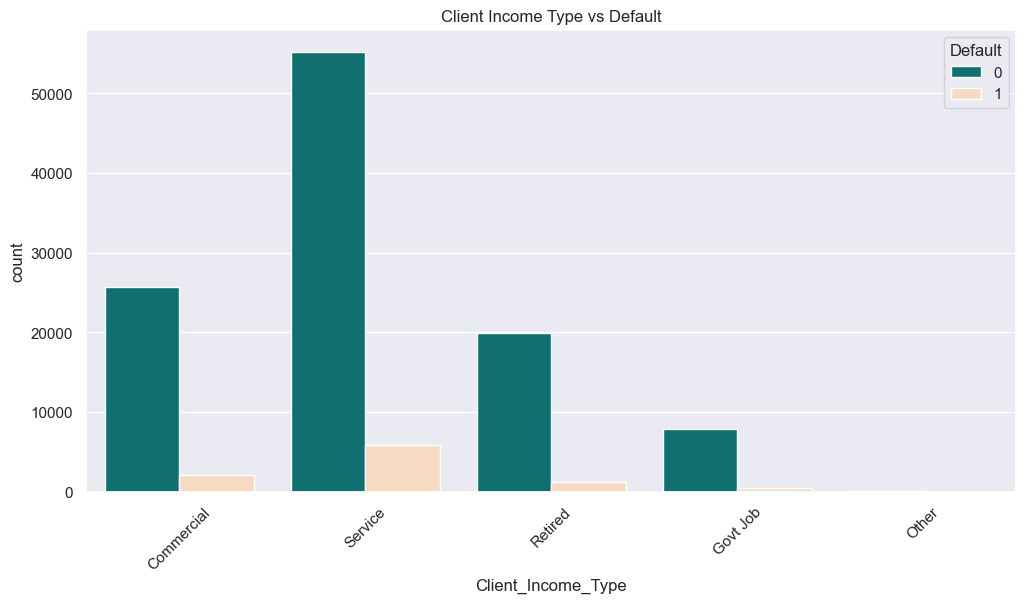

In [92]:
colors = ['#008080', '#FFDAB9']

plt.figure(figsize=(12, 6))
sns.countplot(data=df_raw, x="Client_Income_Type", hue='Default', palette=colors)
plt.title('Client Income Type vs Default')
plt.xticks(rotation=45)
plt.show()

- More number of Defaulters can be observed in `Service` sector

### Client Education by Default

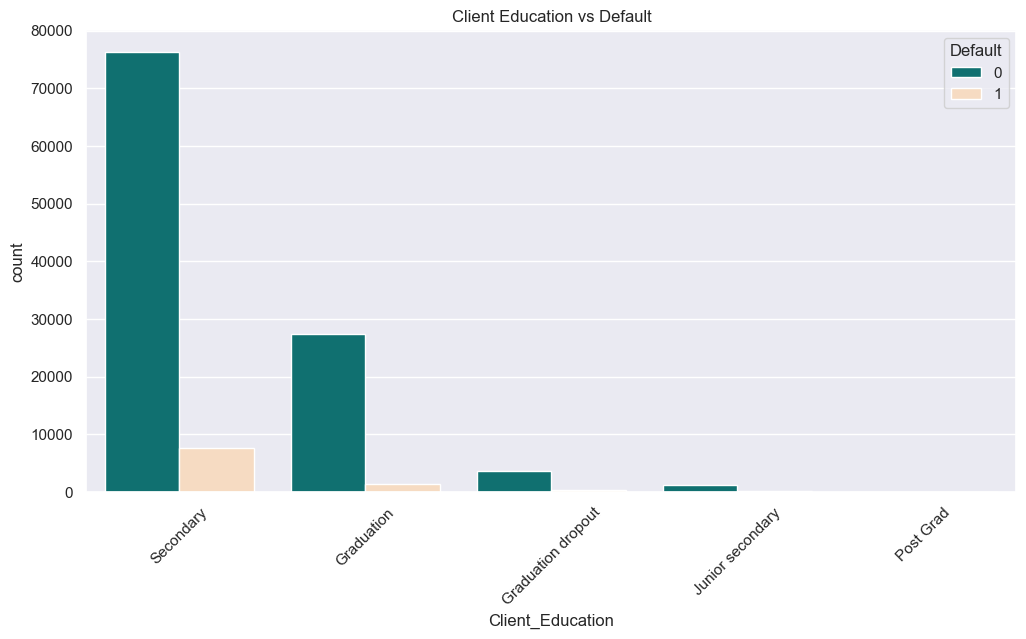

In [93]:
colors = ['#008080', '#FFDAB9']

plt.figure(figsize=(12, 6))
sns.countplot(data=df_raw, x="Client_Education", hue='Default', palette=colors)
plt.title('Client Education vs Default')
plt.xticks(rotation=45)
plt.show()

#### `Observations`
- Clients having `Secondary` level of education have more number of Defaulters
- The qualification of most of the clients is upto `Secondary` or `Graduation` level

### Client Education Level by Loan Amount

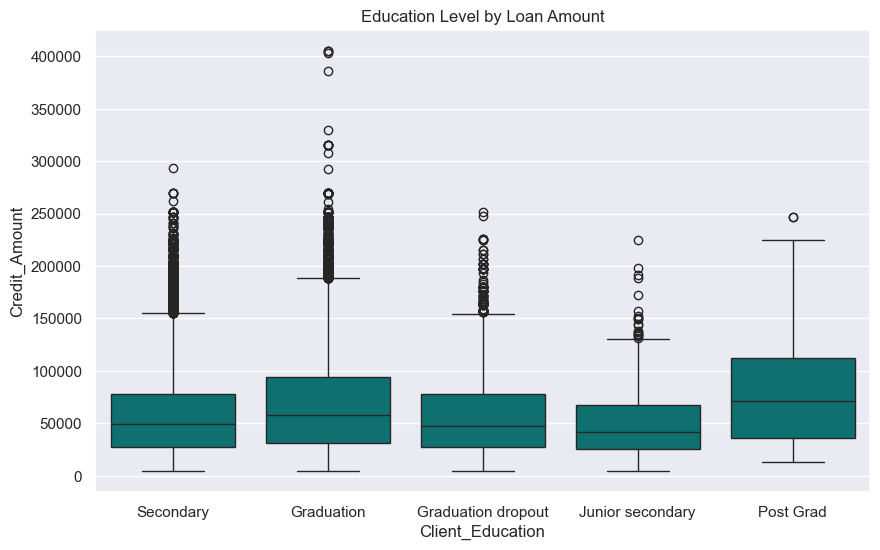

In [94]:
teal_color = '#008080'

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_raw, x='Client_Education', y='Credit_Amount', color=teal_color)
plt.title('Education Level by Loan Amount')
plt.show()

#### `Observations`
- Clients qualified till `Graduation` have most amount of Loan Annuity, followed by `Secondary` and `Graduation dropout`
- Clients educated till `Junior Secondary` and `Post Graduation` have comparitively less amount of Loan Annuity

### Credit Amount of Defaulted Clients by Education

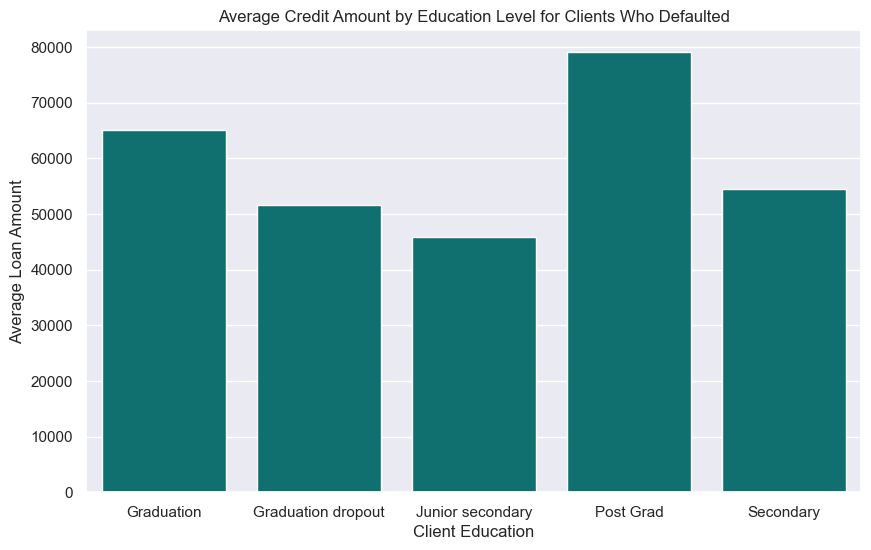

In [95]:
teal_color = '#008080'
df_defaulted = df_raw[df_raw['Default'] == 1]

grouped = df_defaulted.groupby('Client_Education')['Credit_Amount'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=grouped, x='Client_Education', y='Credit_Amount',color=teal_color)
plt.title('Average Credit Amount by Education Level for Clients Who Defaulted')
plt.xlabel('Client Education')
plt.ylabel('Average Loan Amount')
plt.show()

#### `Observations`
- Among all the defaulted clients, the average credit amount of `Post Graduate` clients is highest, followed by clients qualified till `Graduation` and `Secondary`
- The graph shows the average credit amount for which the client is likely to default, based on the client's educational qualification

### Client Marital Status by Default

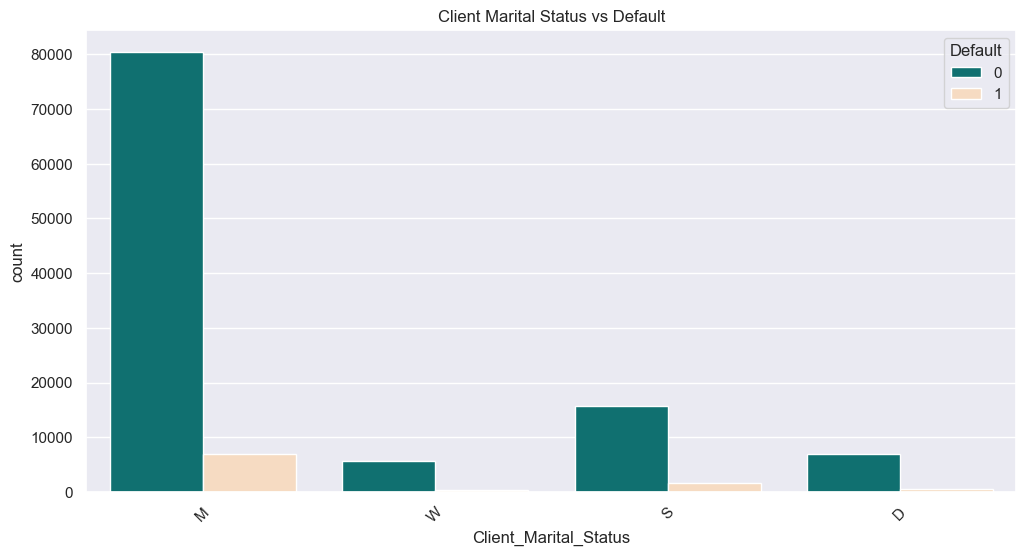

In [96]:
colors = ['#008080', '#FFDAB9']

plt.figure(figsize=(12, 6))
sns.countplot(data=df_raw, x="Client_Marital_Status", hue='Default', palette=colors)
plt.title('Client Marital Status vs Default')
plt.xticks(rotation=45)
plt.show()

#### `Observations`
- Most of the clients, and defaulters, are married

### Distribution of Car Owned, Bike Owned, Active Loan and House Owned

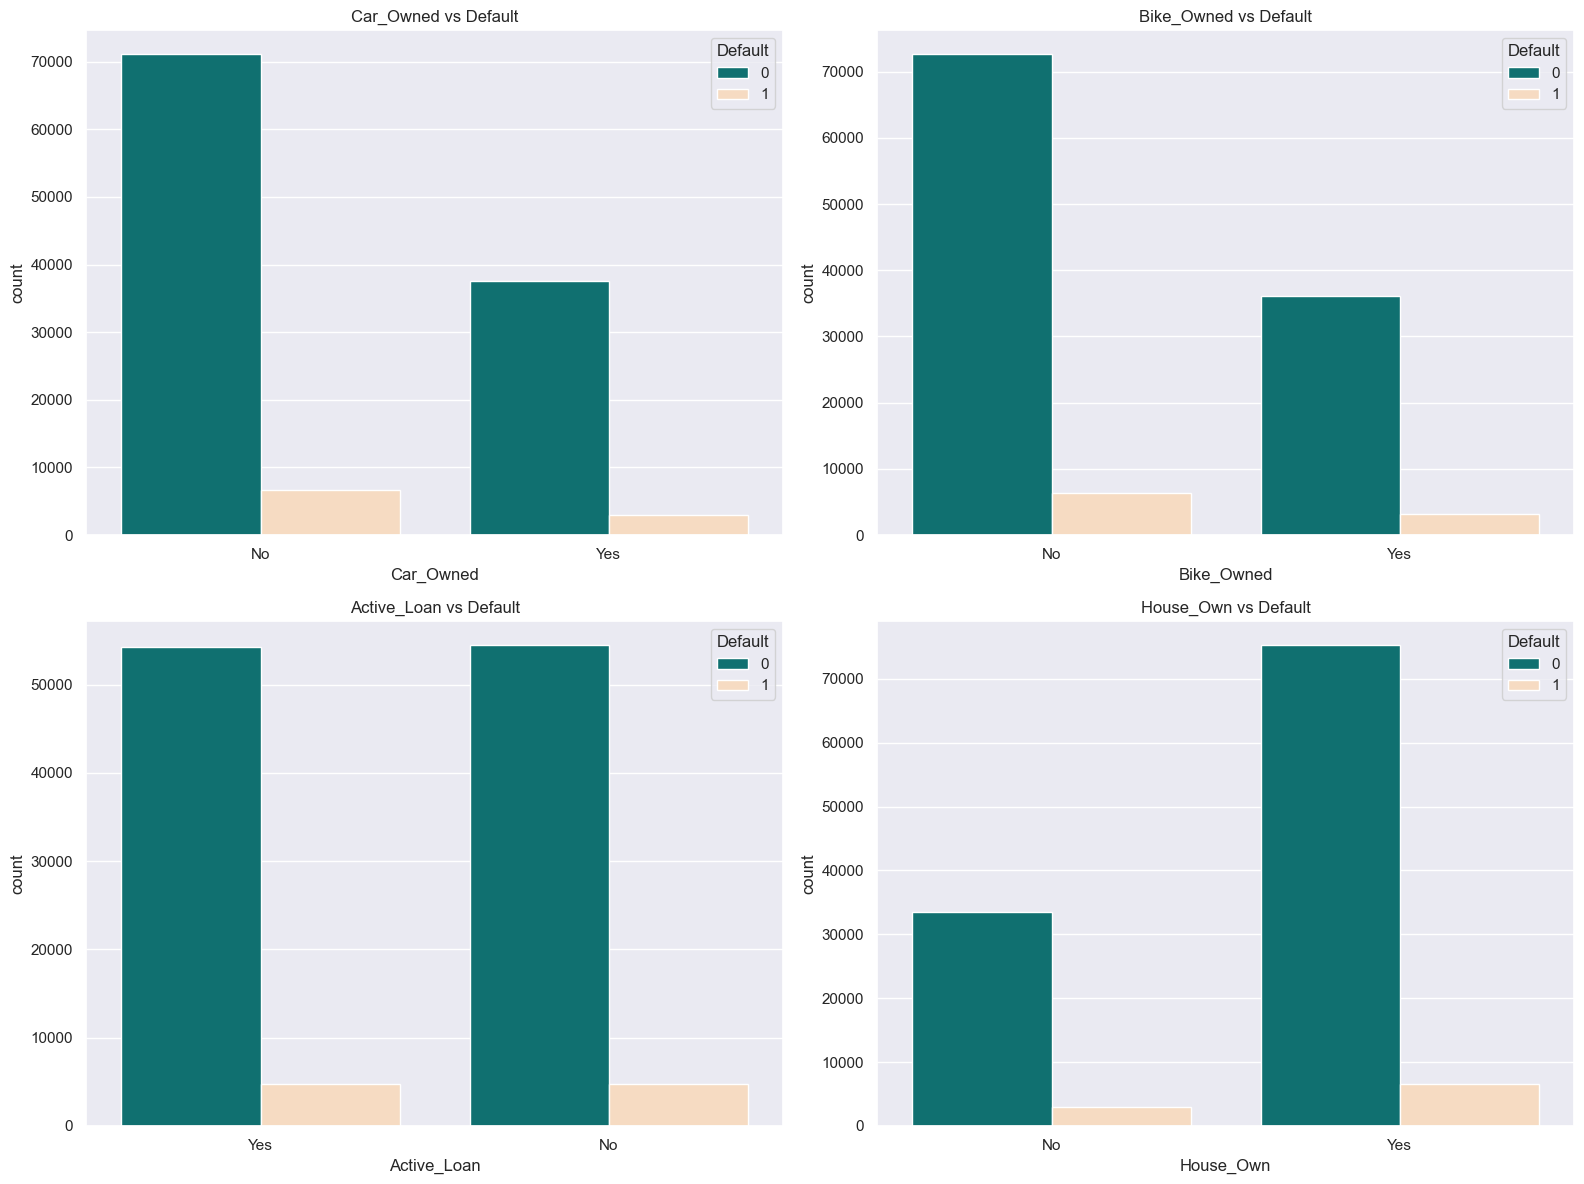

In [97]:
binary_cols = ['Car_Owned', 'Bike_Owned', 'Active_Loan', 'House_Own']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

colors = ['#008080', '#FFDAB9']  

for i, flag in enumerate(binary_cols):
    sns.countplot(data=df_raw, x=flag, hue='Default', ax=axes[i], palette=colors)
    axes[i].set_title(f'{flag} vs Default')

plt.tight_layout()
plt.show()

#### `Observations`
- Clients who do not own a car or a bike are more likely to default
- More number of clients who own a House are defaulters
- Whether a clients has an active loan or not, the number of defaulters in both the cases are almost similar

### Distribution of Client Occupations

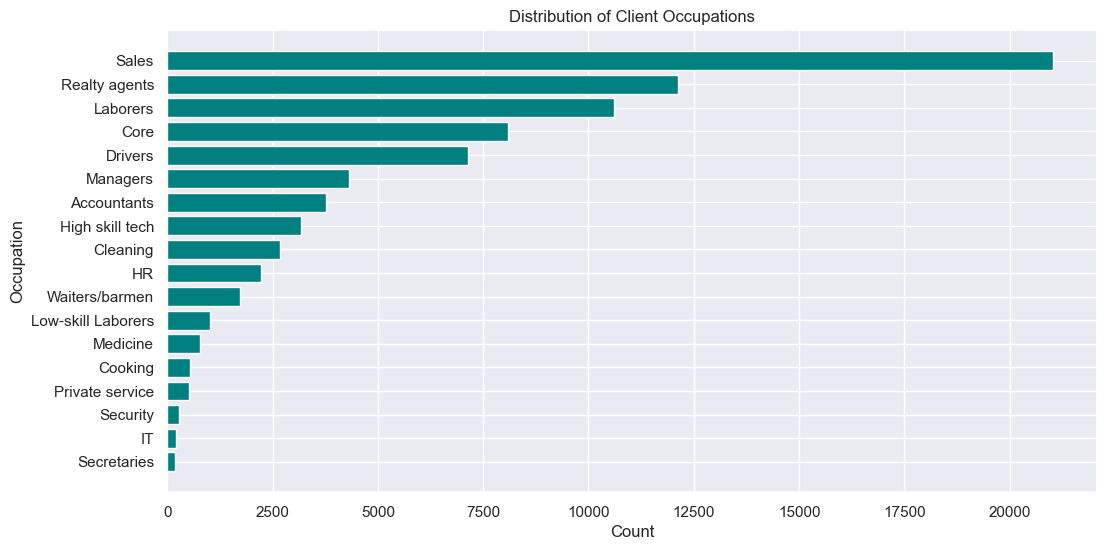

In [98]:
temp_df = df_raw[df_raw['Client_Occupation'].notna()]

unique_occupations = temp_df['Client_Occupation'].unique()
occupation_counts = temp_df['Client_Occupation'].value_counts()

plt.figure(figsize=(12, 6))
plt.barh(unique_occupations, occupation_counts, color='#008080')  # Teal color
plt.gca().invert_yaxis()

plt.xlabel('Count')
plt.ylabel('Occupation')
plt.title('Distribution of Client Occupations')

plt.show()

#### `Observations`
- Sales is the most prevalent occupation among clients, with a significantly higher count than any other occupation

- Realty agents, laborers, and core business roles follow as the next most common occupations, each with counts close to 12,500, 11,000 and 8,000 respectively

- Occupations like IT, Security, and Secretaries are among the least common, with counts well below 1,000

- Given the high number of categories, it would be beneficial to combine similar occupations into more generalized categories to simplify the analysis and model building process

### Combining similar occupations into more generalized categories

In [99]:
def map_occupation(category):
    if pd.isna(category):
        return 'Unknown'
    elif category in ['Sales', 'Realty agents', 'Managers', 'Accountants', 'High skill tech', 'IT']:
        return 'Professional'
    elif category in ['Laborers', 'Core', 'Drivers', 'Cleaning', 'Low-skill Laborers']:
        return 'Skilled Labor'
    elif category in ['HR', 'Waiters/barmen', 'Cooking', 'Private service', 'Security', 'Secretaries']:
        return 'Service'
    elif category == 'Medicine':
        return 'Healthcare'
    else:
        return 'Other'

df_raw['Client_Occupation'] = df_raw['Client_Occupation'].apply(map_occupation)

### Client Occupation by Default

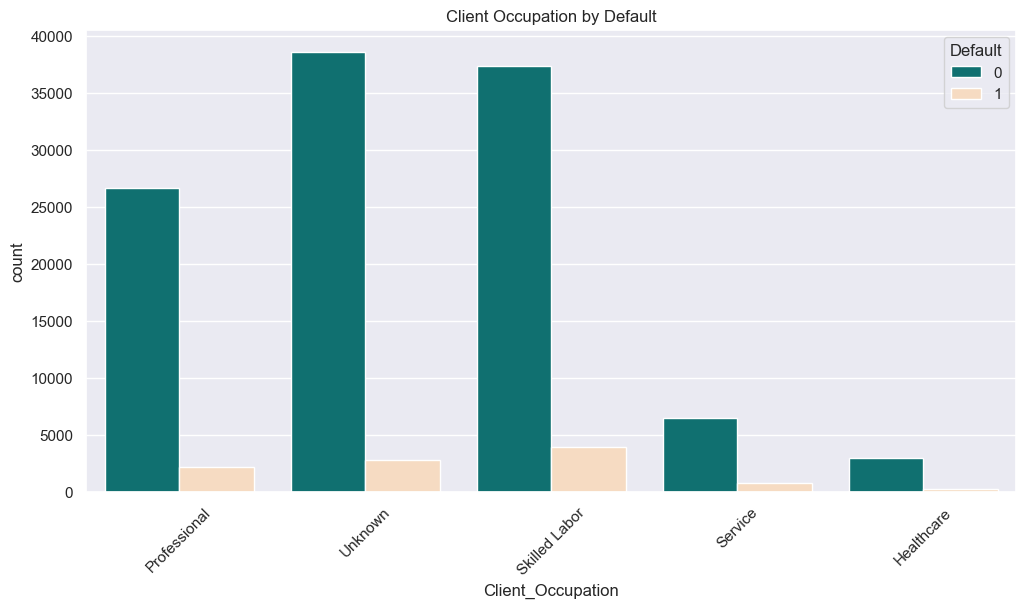

In [100]:
colors = ['#008080', '#FFDAB9']  

plt.figure(figsize=(12, 6))
sns.countplot(data=df_raw, x="Client_Occupation", hue='Default', palette=colors)
plt.title('Client Occupation by Default')
plt.xticks(rotation=45)
plt.show()

#### `Observations`
- `Skilled Labors` have the most number of defaulters, followed by clients whose occupation is `Unknown`
- There are less number of defaulters in `Service` and `Healthcare` sectors

### Distribution of Type of Organization the Client works for

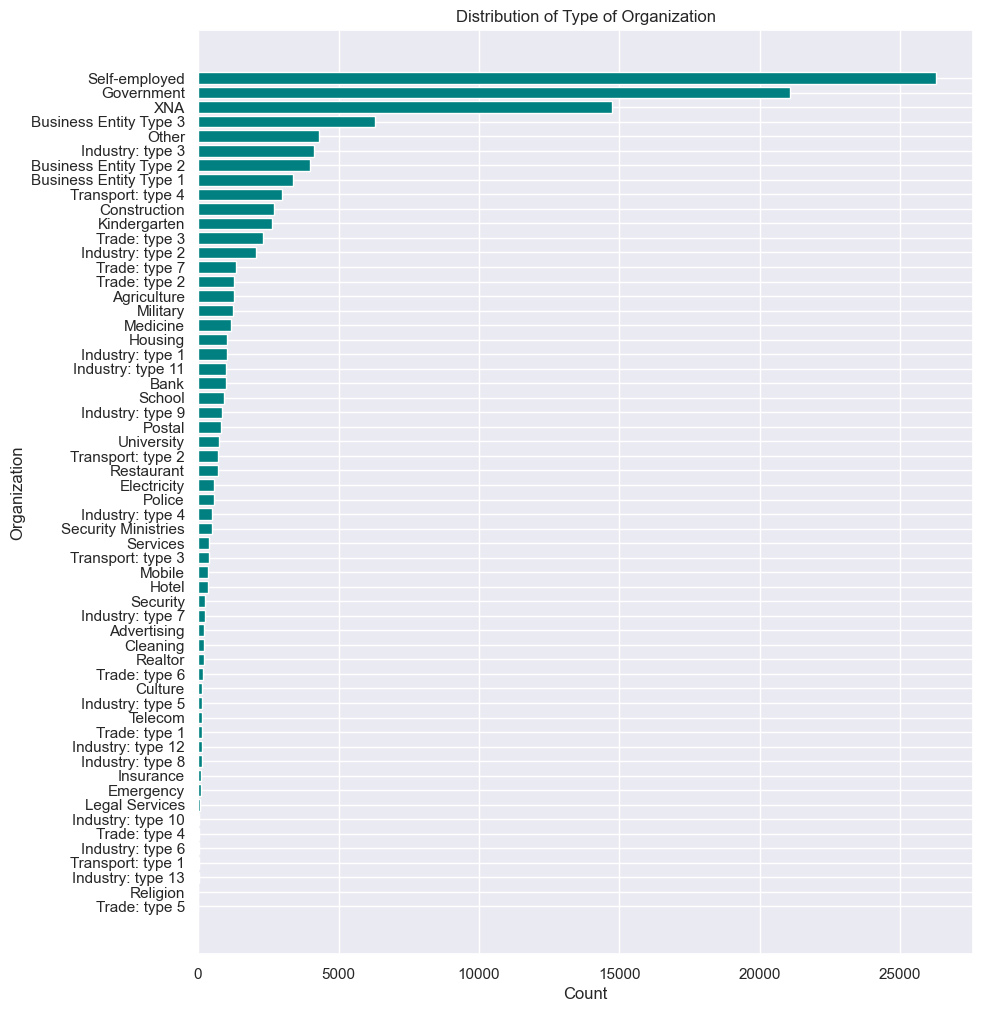

In [101]:
temp_df = df_raw[df_raw['Type_Organization'].notna()]

unique_organizations = temp_df['Type_Organization'].unique()
organization_counts = temp_df['Type_Organization'].value_counts()

plt.figure(figsize=(10, 12))
plt.barh(unique_organizations, organization_counts, color='teal')
plt.gca().invert_yaxis()

plt.xlabel('Count')
plt.ylabel('Organization')
plt.title('Distribution of Type of Organization')

plt.show()

#### `Observations`
- The most common type of organization among clients is self-employed, with a significantly higher count than any other type

- Government and XNA are also prevalent types of organizations, each with substantial counts close to the self-employed category

- Organizations related to Insurance, Telecom, Realtors, Advertising and a few others have the lowest representation, with counts well below 1,000

- Given the high number of categories, it would be beneficial to combine similar occupations into more generalized categories to simplify the analysis and model building process

### Combining similar occupations into more generalized categories

In [102]:
def map_organization(category):
    if pd.isna(category):
        return 'Unknown'
    elif category == 'XNA':
        return 'Unknown'
    elif category in ['Self-employed', 'Government']:
        return 'Public Sector'
    elif category in ['Business Entity Type 3', 'Business Entity Type 2', 'Business Entity Type 1', 'Construction']:
        return 'Business'
    elif category in ['Trade: type 3', 'Trade: type 7', 'Trade: type 2', 'Agriculture']:
        return 'Trade'
    elif category in ['Military', 'Medicine', 'Housing', 'Industry: type 1', 'Industry: type 11', 'Bank', 'School', 'Industry: type 9', 'Postal', 'University']:
        return 'Institution'
    elif category in ['Transport: type 4', 'Transport: type 2', 'Transport: type 3', 'Transport: type 1']:
        return 'Transport'
    else:
        return 'Other'

df_raw['Type_Organization'] = df_raw['Type_Organization'].apply(map_organization)

### Type of Organization the client works for by Default

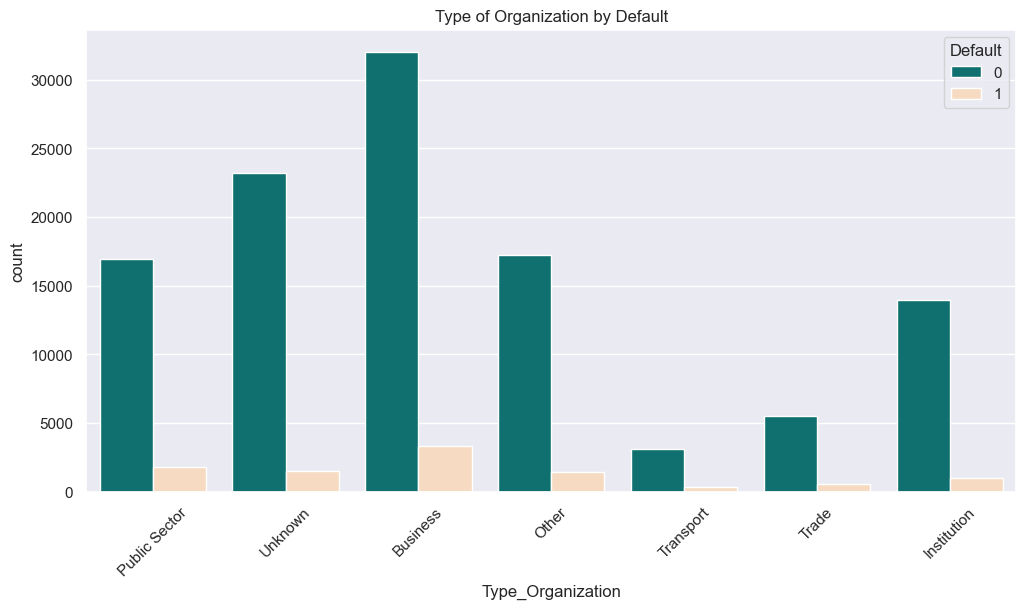

In [103]:
# plt.figure(figsize=(12, 6))
# sns.countplot(data=df_raw, x="Type_Organization", hue='Default')
# plt.title(f'Type of Organization by Default')
# plt.xticks(rotation=45)
# plt.show()
colors = ['#008080', '#FFDAB9']  # Teal and peach colors

plt.figure(figsize=(12, 6))
sns.countplot(data=df_raw, x="Type_Organization", hue='Default', palette=colors)
plt.title('Type of Organization by Default')
plt.xticks(rotation=45)
plt.show()

#### `Observations`
- Clients whose type of organization is `Business`, `Public Sector`, `Unknown` or `Other` have most number of defaulters combined, out of the total defaulters
- Clients from `Transport` sectors have the least number of defaulters, followed by clients from `Trade` sector

### Gender Distribution

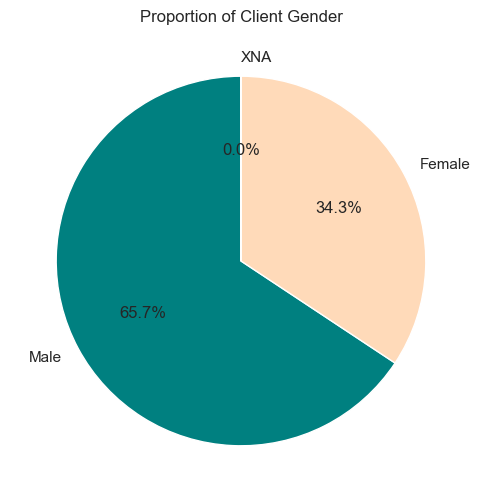

In [104]:
gender_counts = df_raw['Client_Gender'].value_counts()
colors = ['#008080', '#FFDAB9']

plt.figure(figsize=(6, 6))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Proportion of Client Gender')
plt.show()


In [105]:
gender_counts

Client_Gender
Male      78463
Female    40977
XNA           3
Name: count, dtype: int64

#### `Observations`
- #### As there are just 3 records with 'XNA' value, we can impute them with the mode value

In [106]:
df_raw['Client_Gender'].replace('XNA', df_raw['Client_Gender'].mode().iloc[0], inplace=True)

### Number of Family Members of the client by Loan Amount

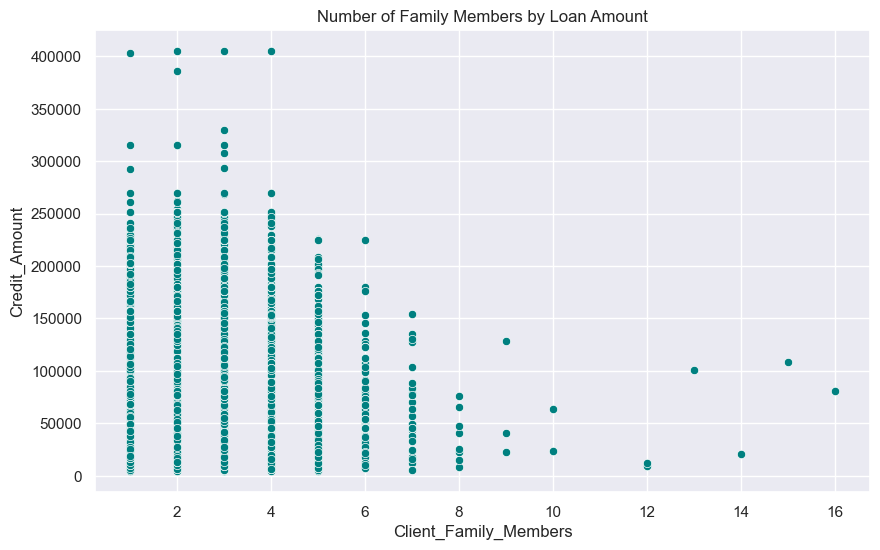

In [107]:

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_raw, x='Client_Family_Members', y='Credit_Amount', color='#008080')  # Teal color
plt.title('Number of Family Members by Loan Amount')
plt.show()

#### `Observations`
- Clients having 2-6 Family Members have a higher Credit Amount

### Rating of the city in which the client lives

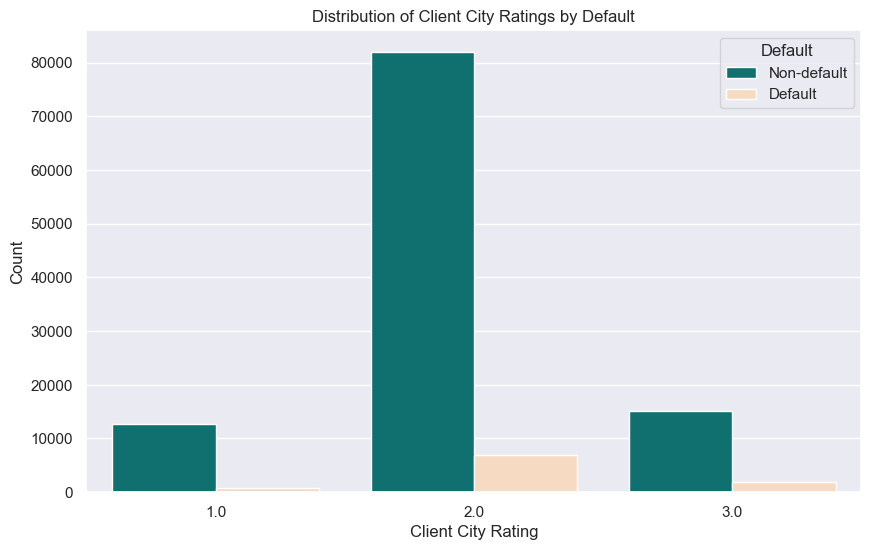

In [108]:
colors = ['#008080', '#FFDAB9']

plt.figure(figsize=(10, 6))
sns.countplot(data=df_raw, x='Cleint_City_Rating', hue='Default', palette=colors)
plt.title('Distribution of Client City Ratings by Default')
plt.xlabel('Client City Rating')
plt.ylabel('Count')
plt.legend(title='Default', loc='upper right', labels=['Non-default', 'Default'])
plt.show()

#### `Observations`
- Most of the defaulters live in the city with a rating of 2

### Checking percentage of Null values after some Preprocessing

In [109]:
null_df = (df_raw.isnull().sum()).sort_values(ascending=False).to_frame()
null_df.columns = ["No of Null values"]
null_df["% of Null values"] = round(null_df["No of Null values"]/len(df_raw)*100, 2)
null_df[null_df["No of Null values"] > 0]

,No of Null values,% of Null values
Own_House_Age,80095,65.73
Score_Source_1,68835,56.49
Social_Circle_Default,61928,50.82
Score_Source_3,26922,22.09
Credit_Bureau,18540,15.21
ID_Days,5985,4.91
Score_Source_2,5686,4.67
Population_Region_Relative,4868,3.99
Loan_Annuity,4826,3.96
Client_Income_Type,3701,3.04


#### `Observations`
- The features `Own_House_Age`, `Score_Source_1`, `Social_Circle_Default` have more than 35% of null values
- These features can be dropped as they are likely to provide unreliable information due to the high proportion of missing data

#### Dropping some features due to high proportion of missing data

In [110]:
percent_missing = (df_raw.isnull().sum() / len(df_raw)) * 100

columns_to_drop = percent_missing[percent_missing > 25].index

df_raw.drop(columns=columns_to_drop, inplace=True)

print("Columns with missing values greater than 25 percent have been dropped.")

df_raw.head()

Columns with missing values greater than 25 percent have been dropped.


,Client_Income,Car_Owned,Bike_Owned,Active_Loan,House_Own,Child_Count,Credit_Amount,Loan_Annuity,Client_Income_Type,Client_Education,Client_Marital_Status,Client_Gender,Loan_Contract_Type,Client_Housing_Type,Population_Region_Relative,Age_Days,Employed_Days,Registration_Days,ID_Days,Homephone_Tag,Workphone_Working,Client_Occupation,Client_Family_Members,Cleint_City_Rating,Client_Permanent_Match_Tag,Client_Contact_Work_Tag,Type_Organization,Score_Source_2,Score_Source_3,Phone_Change,Credit_Bureau,Default
0,6750.0,No,No,Yes,No,0.0,61190.55,3416.85,Commercial,Secondary,M,Male,CL,Home,0.028663,13957.0,1062.0,6123.0,383.0,Yes,No,Professional,2.0,2.0,Yes,Yes,Public Sector,0.478787,NaN,63.0,NaN,0
1,20250.0,Yes,No,Yes,NaN,0.0,15282.00,1826.55,Service,Graduation,M,Male,CL,Home,0.008575,14162.0,4129.0,7833.0,21.0,No,Yes,Unknown,2.0,2.0,Yes,Yes,Public Sector,0.215068,NaN,NaN,NaN,0
2,18000.0,No,No,Yes,No,1.0,59527.35,2788.20,Service,Graduation dropout,W,Male,CL,Family,0.022800,16790.0,5102.0,NaN,331.0,No,No,Professional,2.0,2.0,Yes,Yes,Public Sector,0.552795,0.329655,277.0,0.0,0
3,15750.0,No,No,Yes,Yes,0.0,53870.40,2295.45,Retired,Secondary,M,Male,CL,Home,0.010556,23195.0,365243.0,NaN,775.0,No,No,Unknown,2.0,3.0,Yes,Yes,Unknown,0.135182,0.631355,1700.0,3.0,0
4,33750.0,Yes,No,Yes,No,2.0,133988.40,3547.35,Commercial,Secondary,M,Female,CL,Home,0.020713,11366.0,2977.0,5516.0,4043.0,No,No,Skilled Labor,4.0,1.0,Yes,Yes,Business,0.301182,0.355639,674.0,1.0,0


### Checking number of Categorical and Numeric Columns

In [111]:
numeric_cols = df_raw.select_dtypes(include=['number']).columns.tolist()
categorical_cols = df_raw.select_dtypes(include=['object']).columns.tolist()
print(f"{len(numeric_cols)} numeric_cols, {len(categorical_cols)} categorical_cols")

16 numeric_cols, 16 categorical_cols


### Selecting features having more than 3 categories to plot their histograms and box plots

In [112]:
histogram_numeric_cols = []

for col in numeric_cols:
    if len(df_raw[col].unique()) > 3:
        histogram_numeric_cols.append(col)

histogram_numeric_cols

['Client_Income',
 'Child_Count',
 'Credit_Amount',
 'Loan_Annuity',
 'Population_Region_Relative',
 'Age_Days',
 'Employed_Days',
 'Registration_Days',
 'ID_Days',
 'Client_Family_Members',
 'Cleint_City_Rating',
 'Score_Source_2',
 'Score_Source_3',
 'Phone_Change',
 'Credit_Bureau']

- We select columns with more than 3 unique values for plotting their histograms to observe and analyze their distributions
- This will help us understand the underlying patterns and variability within the data, facilitating more informed decisions for further analysis and modeling

## Histograms

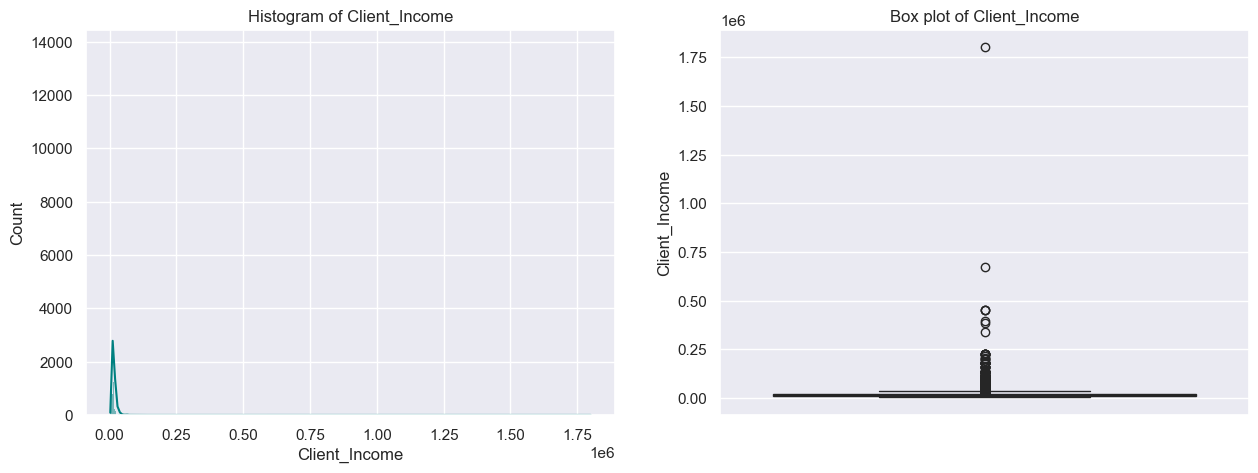

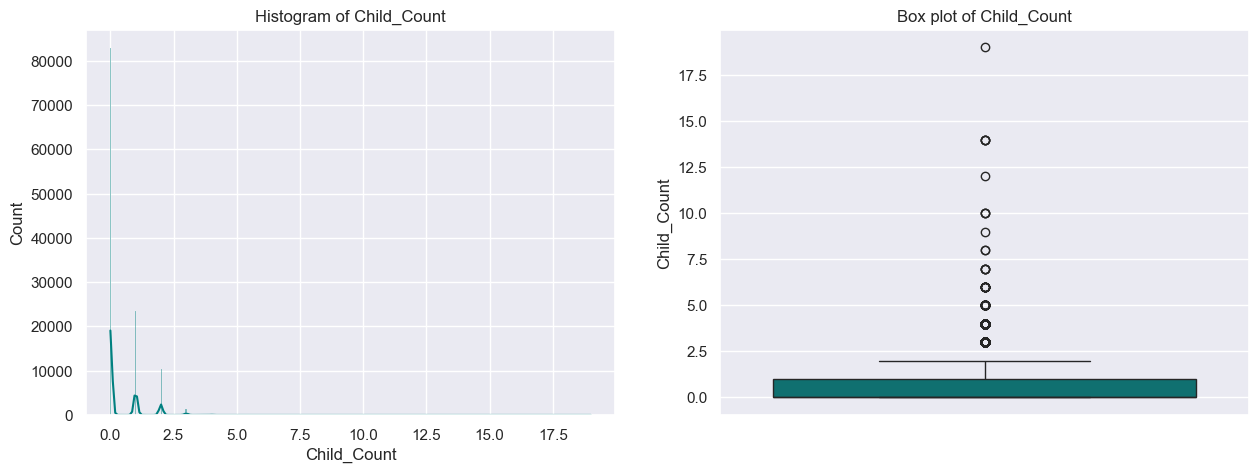

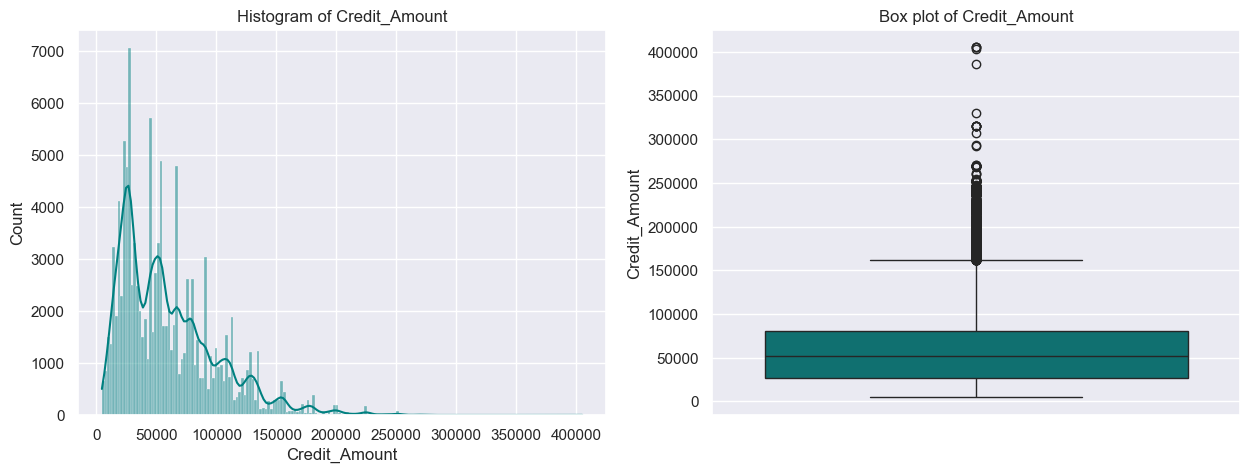

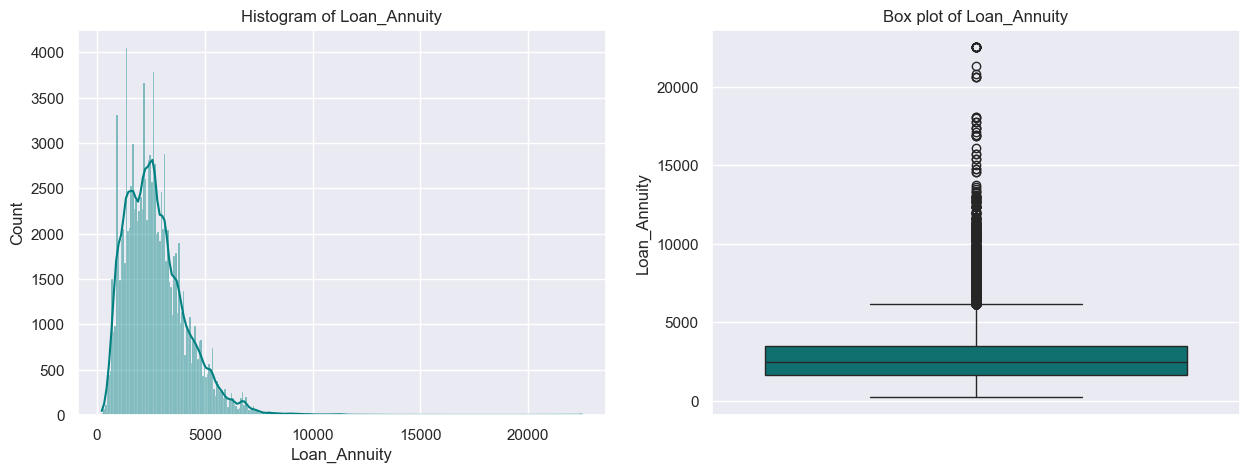

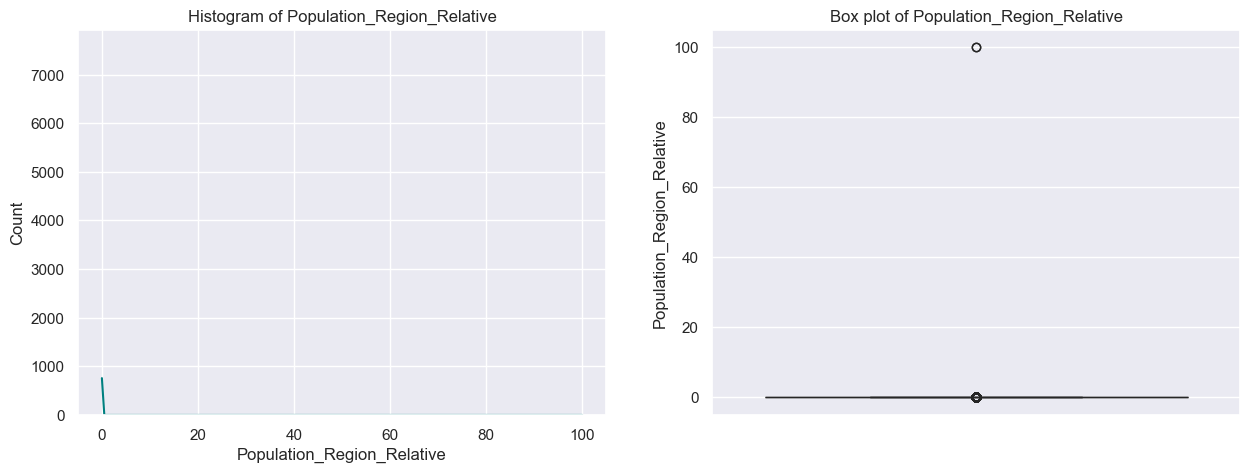

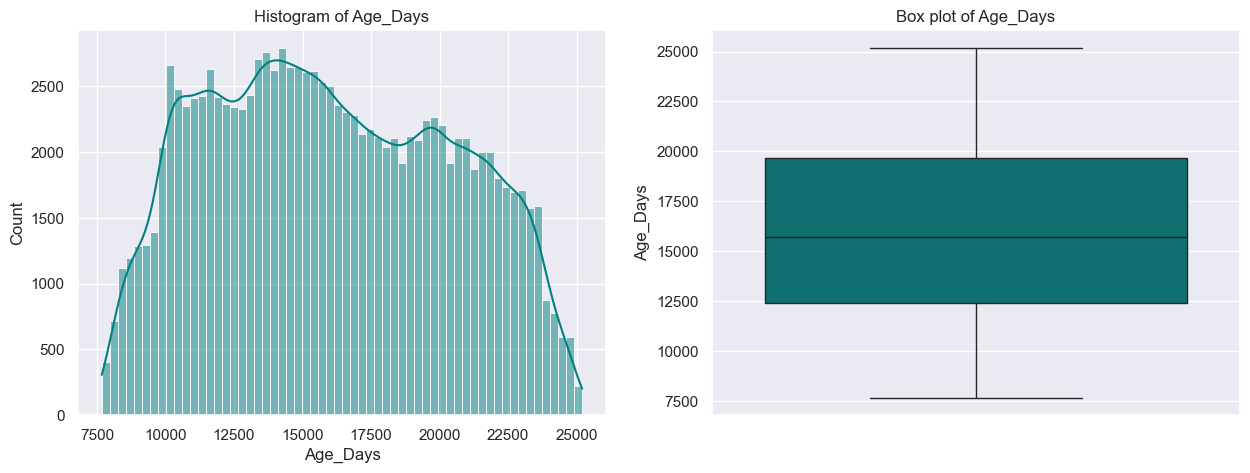

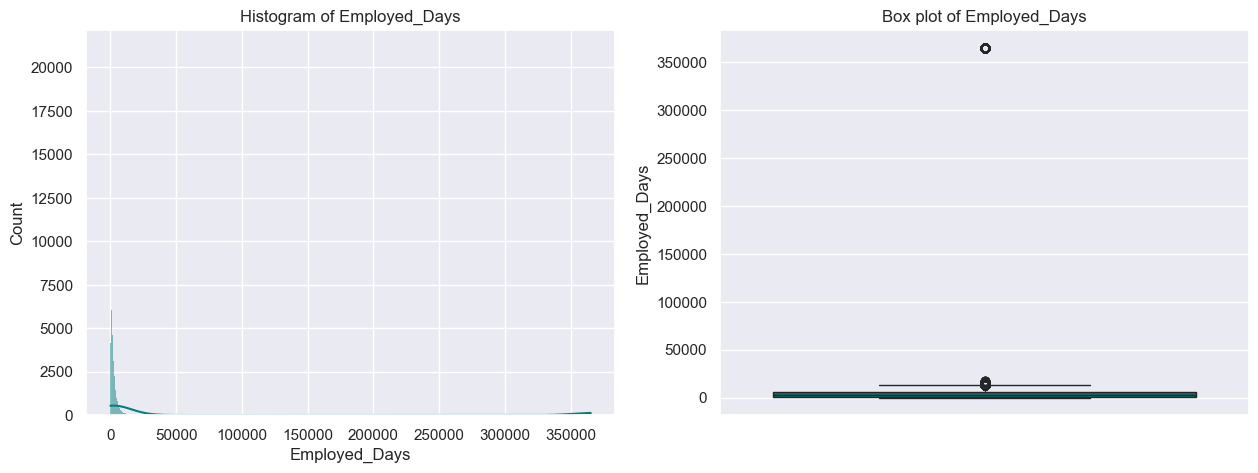

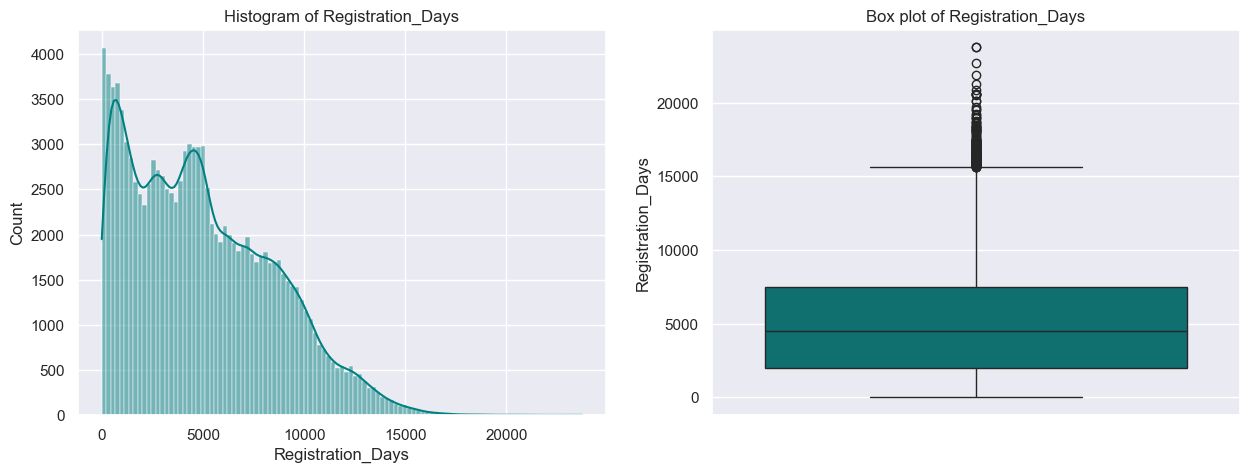

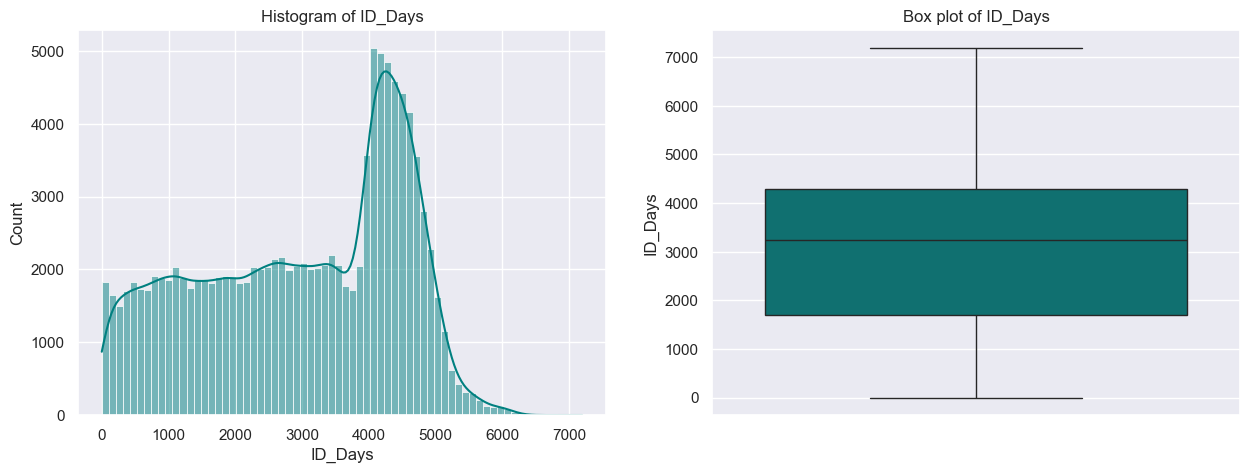

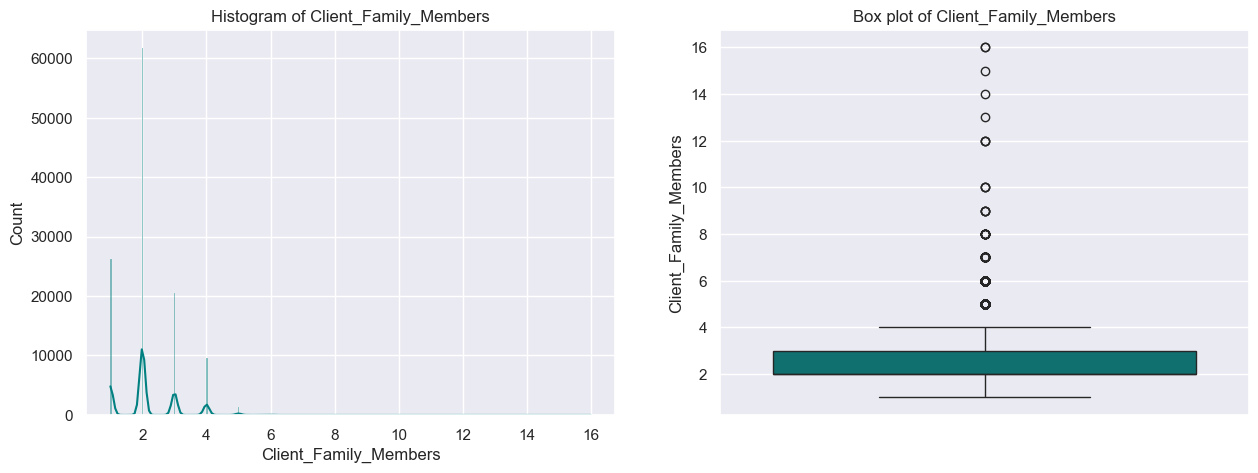

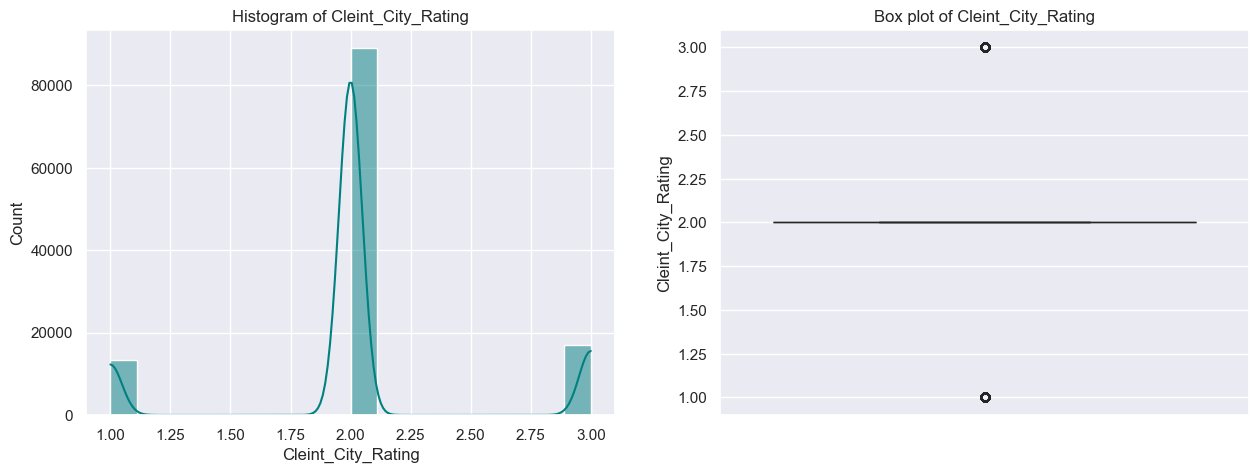

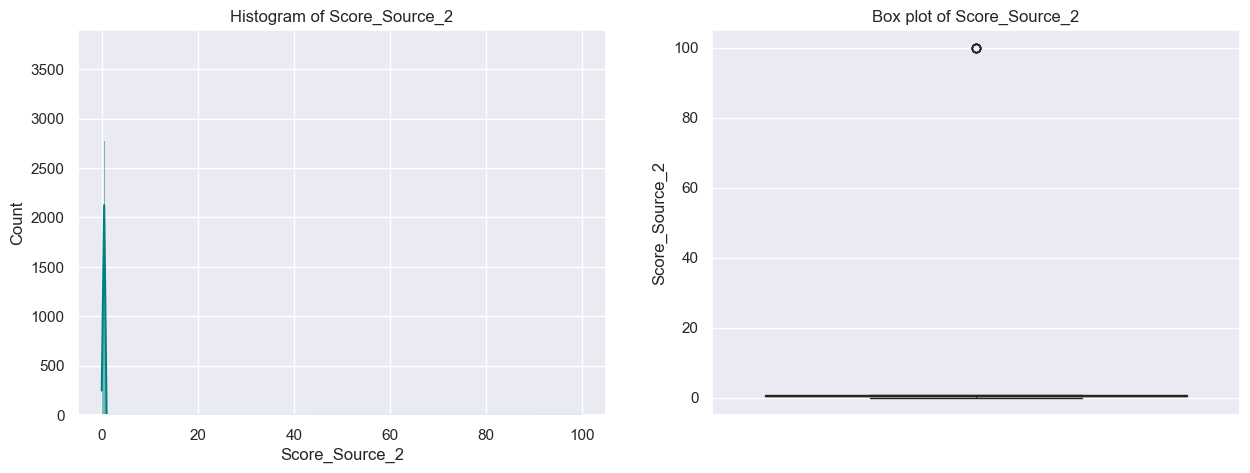

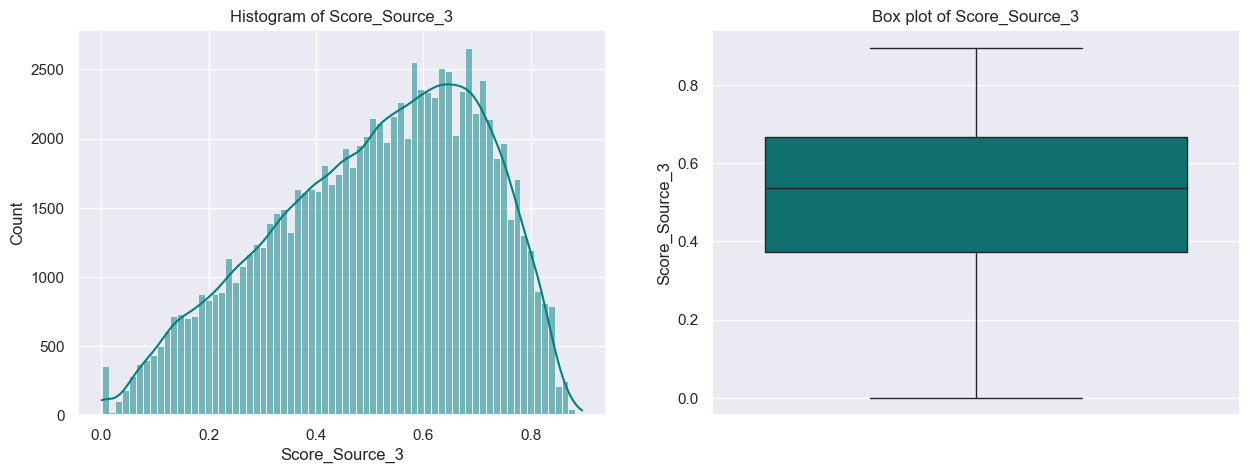

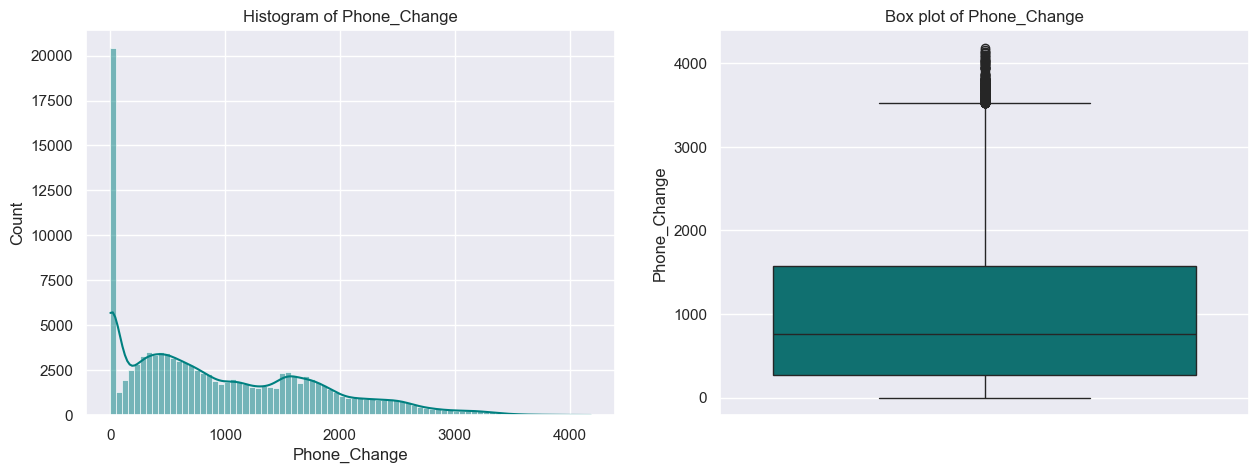

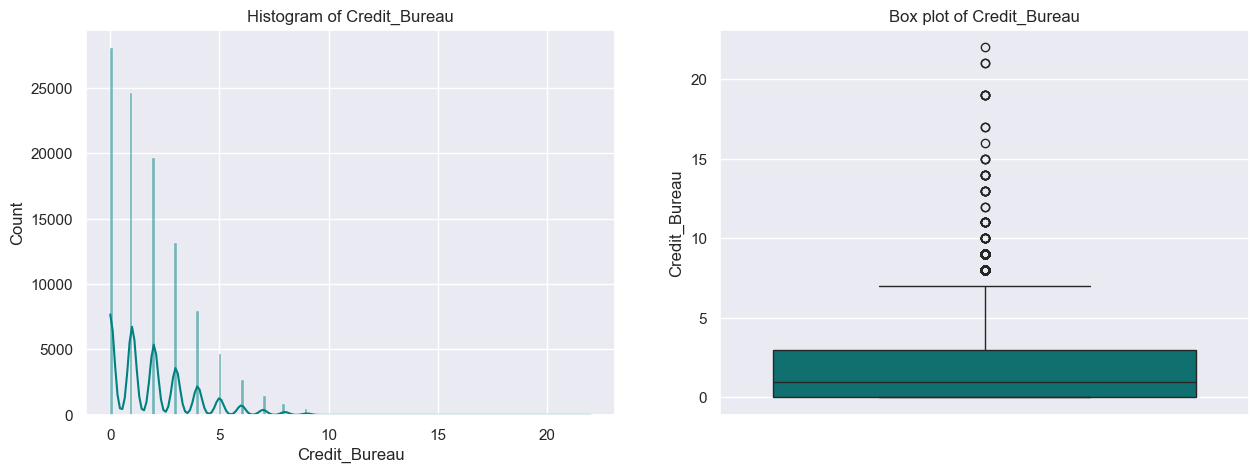

In [113]:
# def plot_histograms_and_boxplots(df, numeric_cols):
#     for col in numeric_cols:
#         fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        
        
#         sns.histplot(df[col], kde=True, ax=axes[0])
#         axes[0].set_title(f'Histogram of {col}')
        
        
#         sns.boxplot(y=df[col], ax=axes[1])
#         axes[1].set_title(f'Box plot of {col}')
        
#         plt.show()
def plot_histograms_and_boxplots(df, numeric_cols):
    for col in numeric_cols:
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        
        # Set the color palette to teal
        teal_color = 'teal'
        
        # Histogram with KDE
        sns.histplot(df[col], kde=True, ax=axes[0], color=teal_color)
        axes[0].set_title(f'Histogram of {col}')
        
        # Box plot
        sns.boxplot(y=df[col], ax=axes[1], color=teal_color)
        axes[1].set_title(f'Box plot of {col}')
        
        plt.show()

plot_histograms_and_boxplots(df_raw, histogram_numeric_cols)

#### `Observations`

- **Client_Income**

      The distribution is heavily right-tailed with notable outliers, indicating a significant number of clients with lower incomes and a few with exceptionally high incomes

- **Child_Count**

      Most clients have 0-2 children, with higher counts being outliers, suggesting that large families are relatively rare in the dataset

- **Credit_Amount**

      The feature is right-tailed with outliers starting around 1,60,000 up to 4,00,000, showing that while most clients have moderate credit amounts, there are some with very high credit amounts

- **Loan_Annuity**

      This feature is right-tailed with outliers ranging from 6,000 to 24,000, indicating that while most loan annuities are lower, there are a few very high annuities

- **Population_Region_Relative**

      Outliers are present near 0 and 100, suggesting that some regions have extremely low or high population densities relative to others

- **Age_Days**

      The distribution is close to normal without any outliers, indicating a typical age distribution among clients

- **Employed_Days**

      This feature is heavily right-tailed with outliers near 3,50,000, which is unlikely. Entries above the maximum whisker can be dropped to remove these unrealistic values

- **Registration_Days**

      The distribution is slightly right-tailed with outliers from 15,500 to 24,500, indicating that some clients have not changed their registration since many days, while applying the loan

- **ID_Days**

      The distribution is mostly normal with no outliers, suggesting a typical spread in the number of days before applying the loan the client changed his/her identity document

- **Client_Family_Members**

      There are outliers, and capping values till 6 can help normalize the distribution and mitigate the impact of large family sizes

- **Client_City_Rating**

      Client city is rated on a scale of 1 to 3

- **Score_Source_2**

      The feature is right-tailed with outliers near 100, indicating that most scores are lower with a few very high scores

- **Score_Source_3**

      The distribution looks normal with no outliers, suggesting a typical spread of scores without extreme values

- **Phone_Change**

      The distribution is right-tailed with outliers between 3,500 and 4,250, showing that while most phone changes are recent, some clients have changed not their phones since years

- **Credit_Bureau**

      The feature is right-tailed with a wavy KDE plot and outliers from 7 to 22, indicating a varied number of enquiries by clients in the past year, with fewer clients having a very high number of enquiries

### Handling Outliers

In [114]:
def handle_outliers(df):

    # Repalce the outlier value by uperbound(top whisker)
    def cap_outliers(series, lower_bound, upper_bound):
        series = np.where(series > upper_bound, upper_bound, series)
        # series = np.where(series < lower_bound, lower_bound, series)
        return series

    columns_to_cap = ['Population_Region_Relative', 'Score_Source_2']

    for column in columns_to_cap:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[column] = cap_outliers(df[column], lower_bound, upper_bound)

    #Removing the outliers as they are unrealistic
    columns_to_filter = ['Employed_Days']

    for column in columns_to_filter:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    return df


df_raw = handle_outliers(df_raw)

#### Plotting histograms and box plots after handling outliers

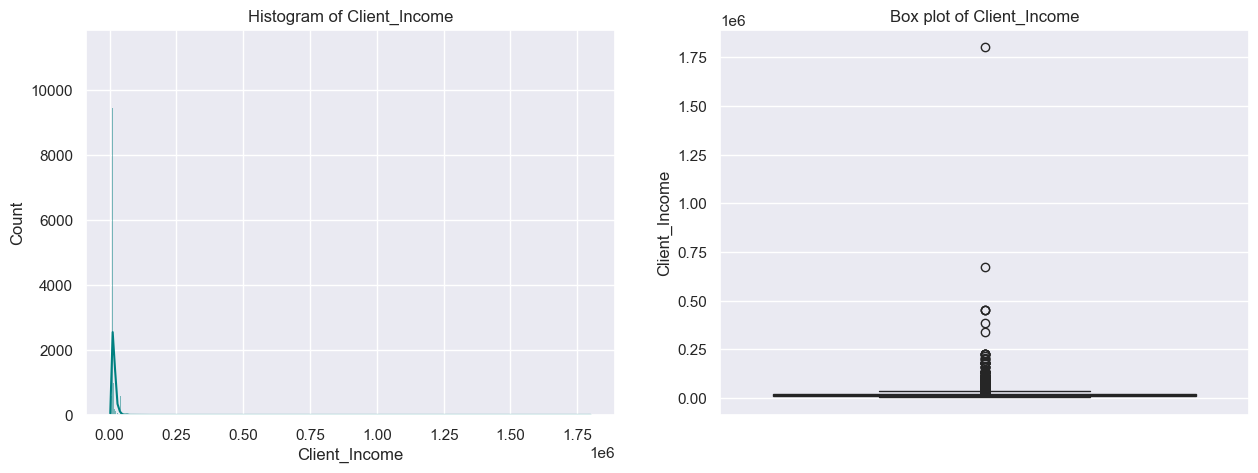

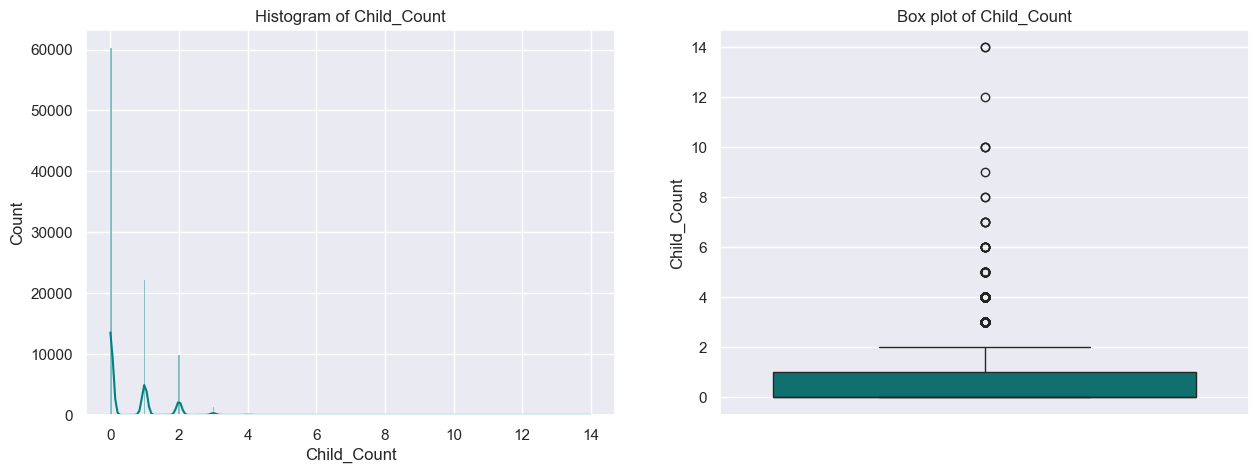

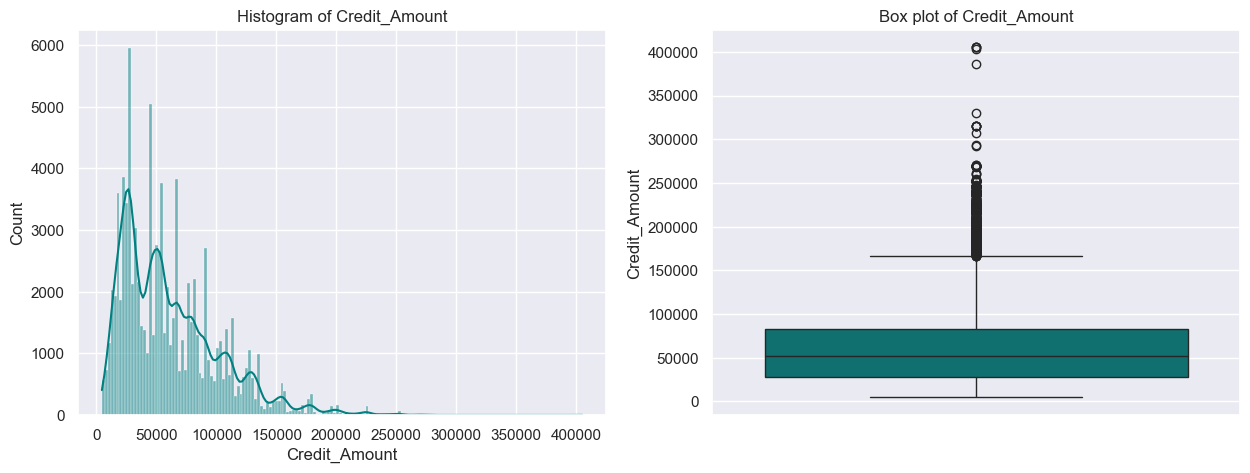

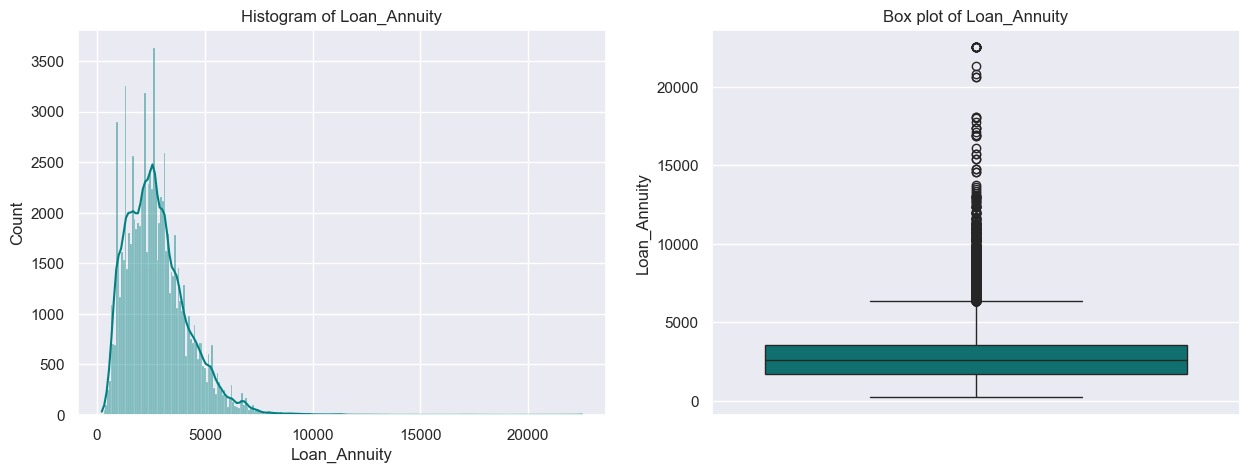

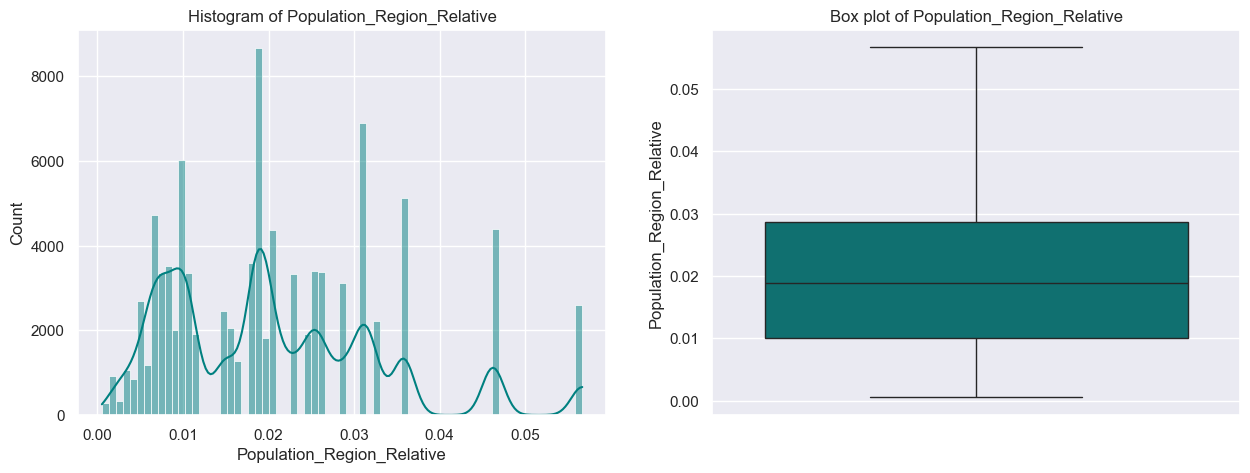

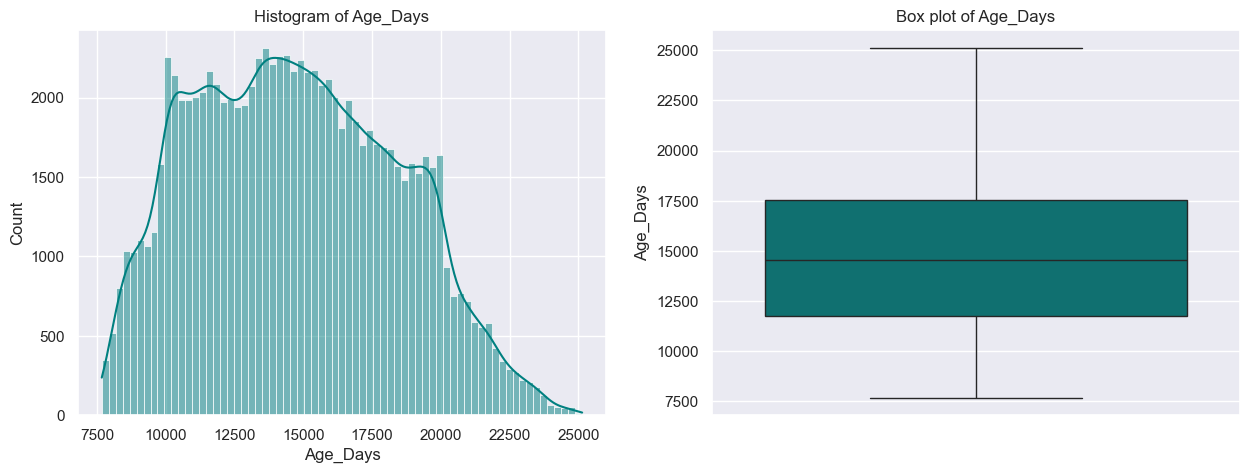

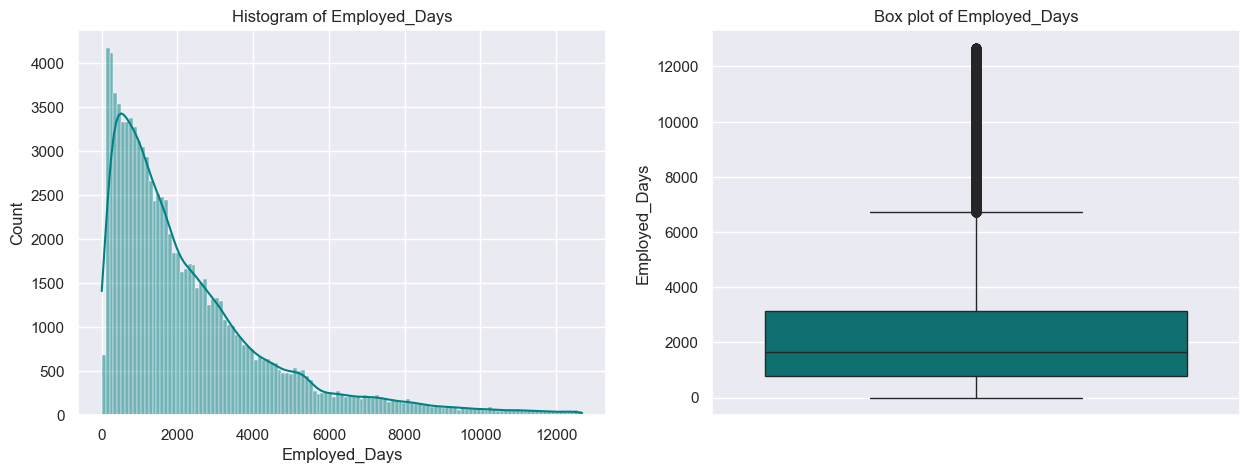

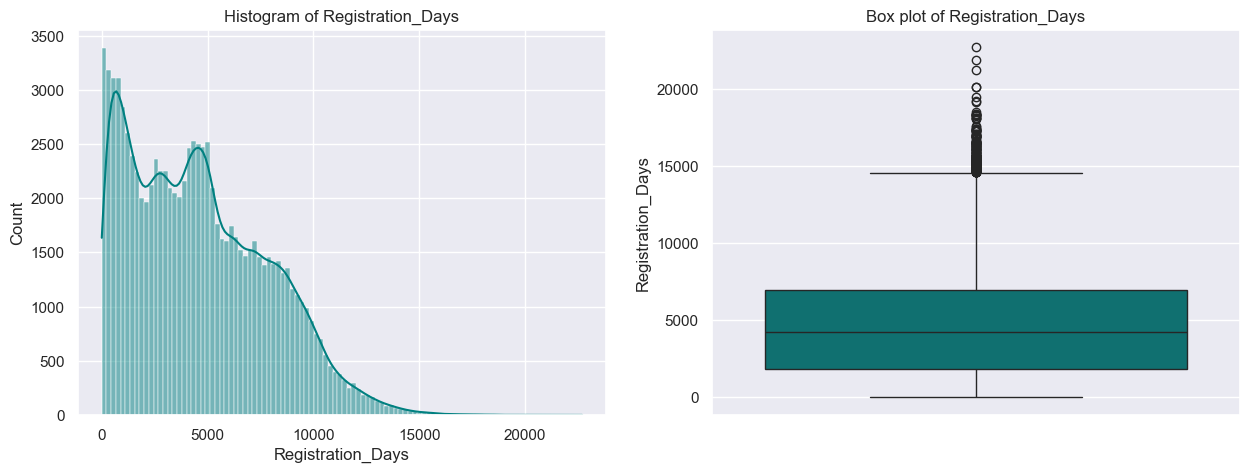

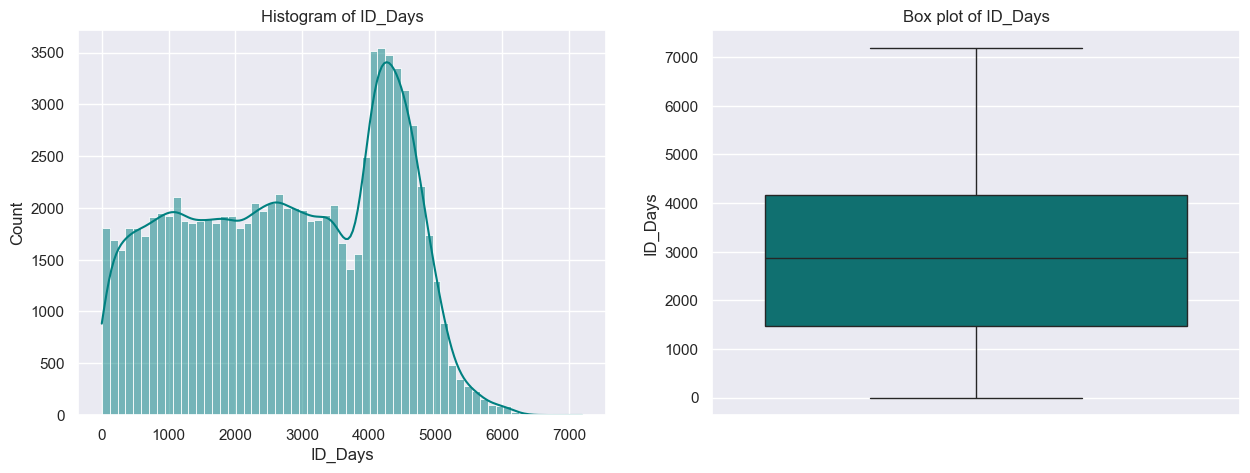

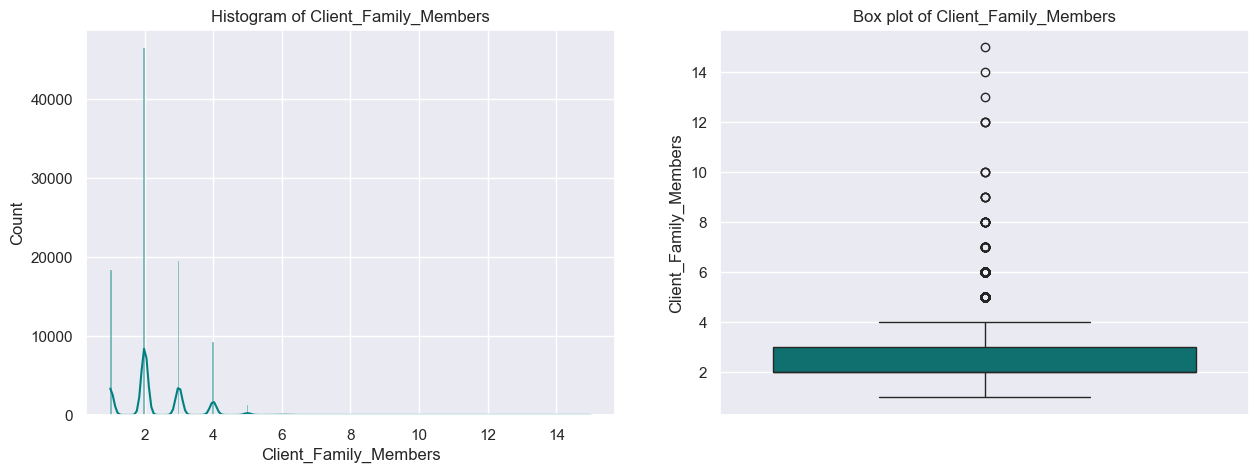

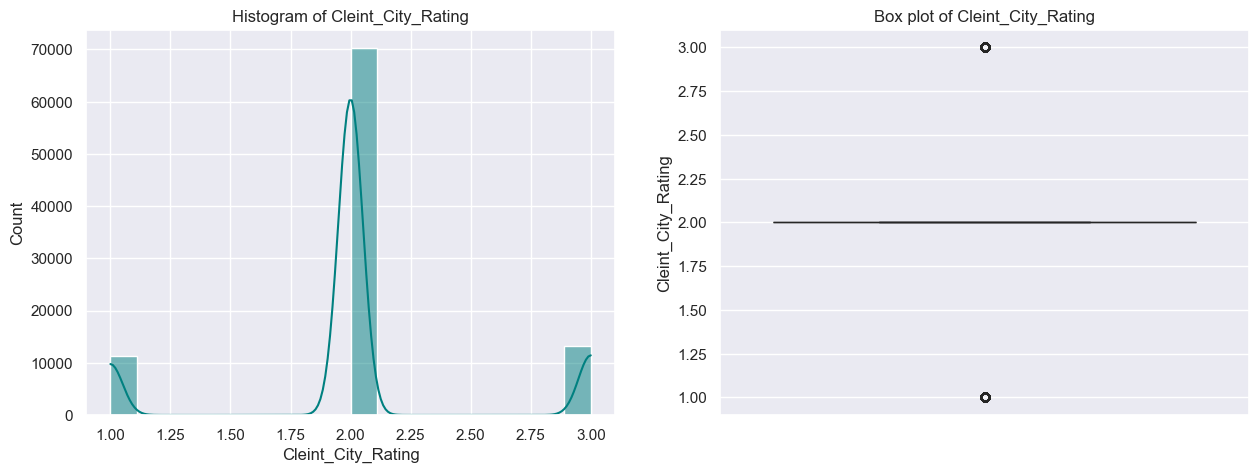

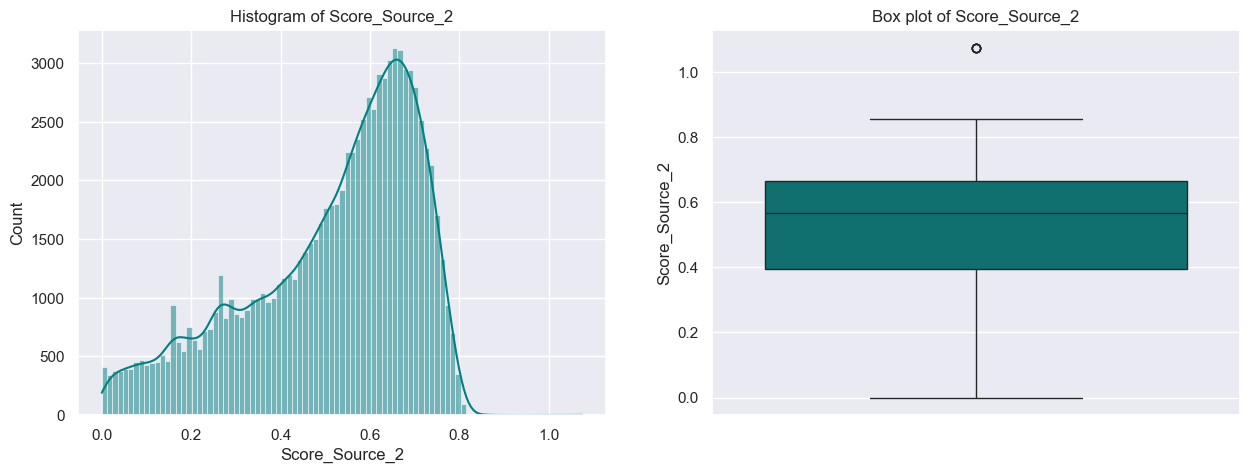

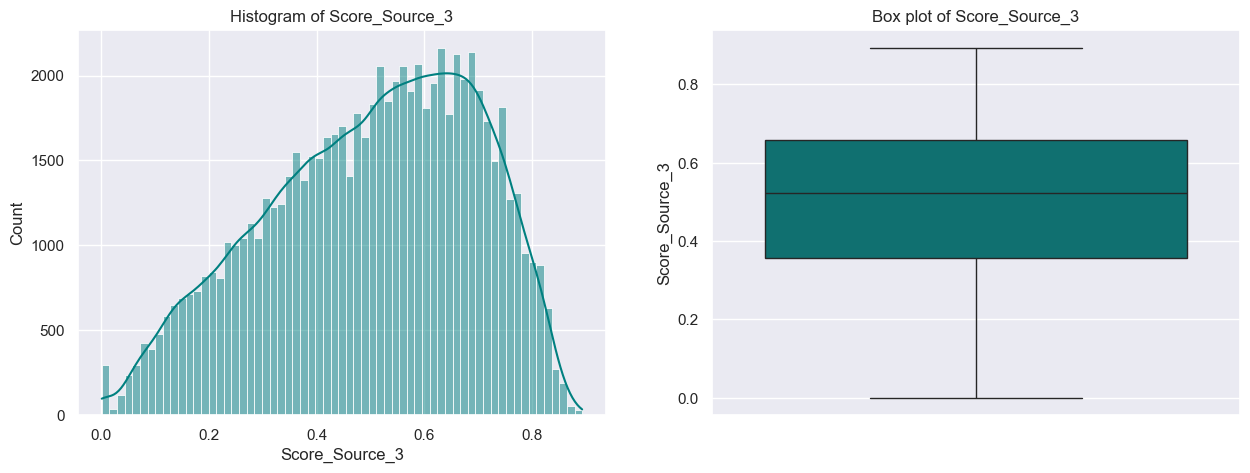

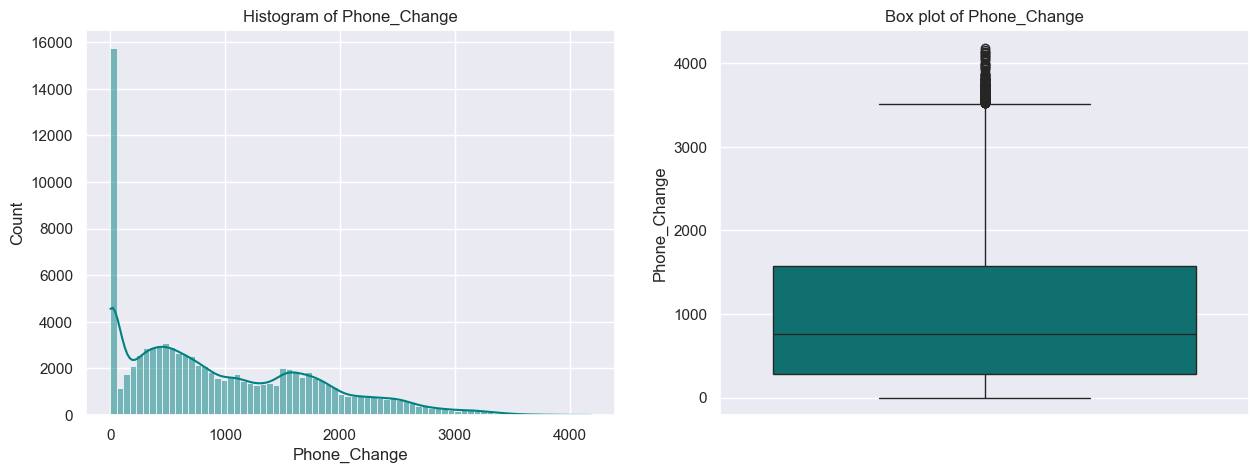

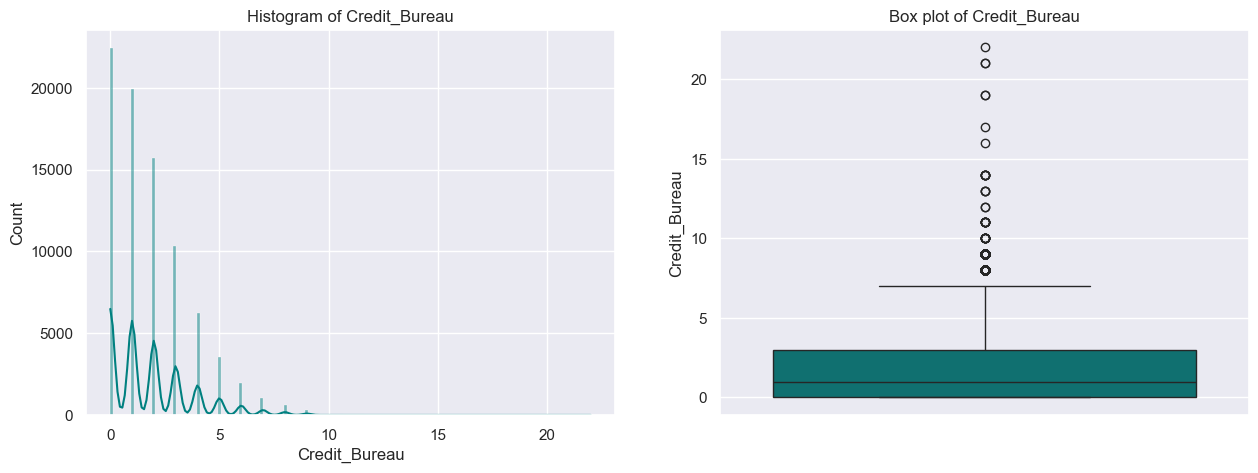

In [115]:
plot_histograms_and_boxplots(df_raw, histogram_numeric_cols)

#### `Observations`

- **Client_Income**, **Child_Count**, **Credit_Amount**, **Loan_Annuity**, **Registration_Days**, **Client_Family_Members**, **Client_City_Rating**, **Phone_Change**, **Credit_Bureau**

      The outliers in these features have been left unchanged as they can be considered realistic representations of the data
      
      These extreme values, although far from the average, reflect genuine cases and provide valuable insights into the diversity and variability within the dataset
      
      By retaining these outliers, we preserve the integrity of the data

- **Population_Region_Relative**

      Outliers near 0 and 100 have been capped based on the IQR method, providing a more consistent view of population density across regions

- **Employed_Days**

      Entries with impossible values (outliers near 350,000) have been removed, reducing the skewness of the distribution and eliminating unrealistic data points

- **Score_Source_2**

      Right-tailed outliers near 100 have been capped based on the IQR method, reducing the skewness and bringing the extreme values within a more reasonable range, creating a more balanced distribution

### Finding **correlation** between `numeric features` and target variable `Default`

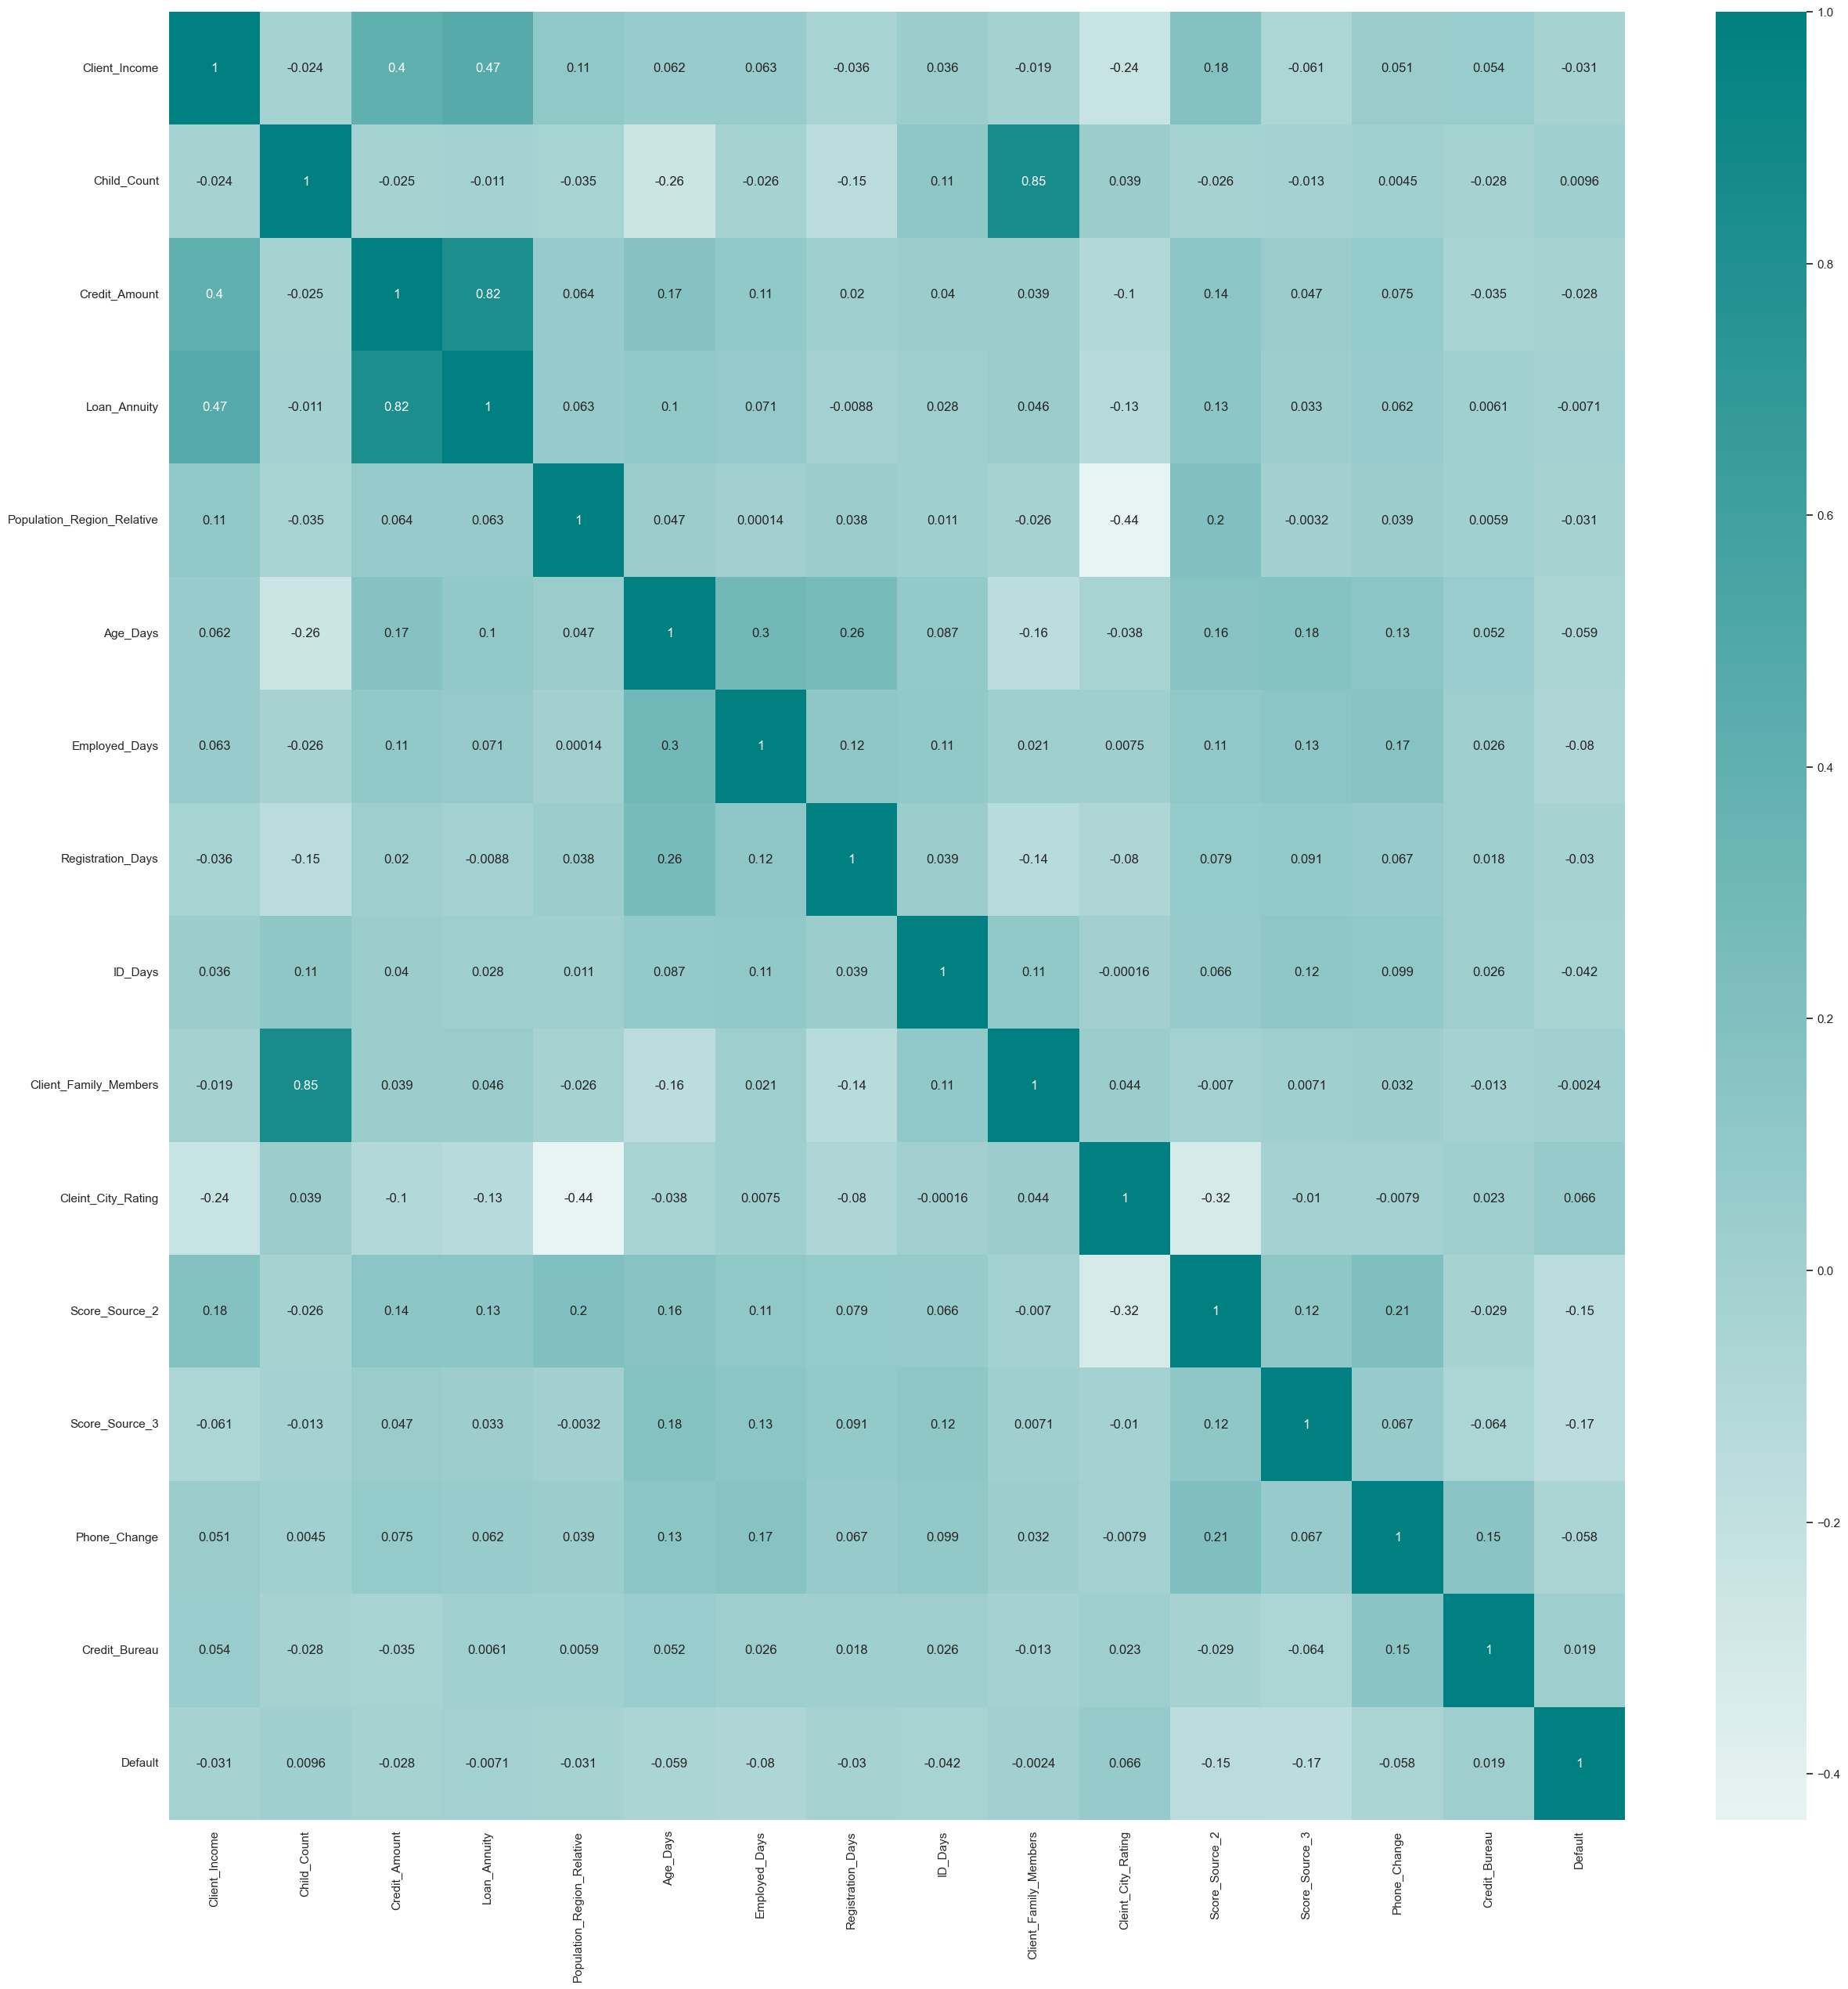

In [116]:
plt.figure(figsize=(30, 30))
cmap = sns.light_palette("teal", as_cmap=True)

sns.heatmap(df_raw[df_raw.select_dtypes(include=['number']).columns.tolist()].corr(method='spearman'), 
            fmt='.2g', annot=True, cmap=cmap)
plt.show()


#### `Observations`

- `Child_Count` and `Client_Family_Members` have a strong positive correlation, as families with more children naturally have more family members

- `Credit_Amount` and `Loan_Annuity` are highly correlated

- We will retain all the columns that have a correlation of less than -0.025 and greater than +0.025 with `Default` for model training

### Selecting columns having a higher correlation with the target variable

In [117]:
# Spearman correlation measures how well the relationship between two variables can be described using a monotonic function
spearman_corr = df_raw[df_raw.select_dtypes(include=['number']).columns.tolist()].corr(method='spearman')
default_corr = spearman_corr['Default']


filtered_columns = default_corr[(default_corr < -0.025) | (default_corr > 0.025)].index.tolist()
if 'Default' in filtered_columns:
    filtered_columns.remove('Default')

filtered_columns

['Client_Income',
 'Credit_Amount',
 'Population_Region_Relative',
 'Age_Days',
 'Employed_Days',
 'Registration_Days',
 'ID_Days',
 'Cleint_City_Rating',
 'Score_Source_2',
 'Score_Source_3',
 'Phone_Change']

In [118]:
columns_to_drop = []

for col in numeric_cols:
    if col not in filtered_columns and col != 'Default':
        columns_to_drop.append(col)

columns_to_drop

['Child_Count', 'Loan_Annuity', 'Client_Family_Members', 'Credit_Bureau']

- `Loan_Annuity` may affect the financial decisions of the client and result in the client defaulting, thus being crucial in predicting if a client will default or not 

- `Client_Family_Members` is proportional to client's overall spend, which can affect in the defaulting of loan

- Lots of credit enquries (`Credit_Bureau`) can indicate a higher risk of the client defaulting on the loan

- Thus, we will retain `Loan_Annuity`, `Client_Family_Members` and `Credit_Bureau`

### Retaining some features as due to their importance

In [119]:
columns_to_drop.remove('Loan_Annuity')
columns_to_drop.remove('Client_Family_Members')
columns_to_drop.remove('Credit_Bureau')
columns_to_drop

['Child_Count']

In [120]:
df_raw.drop(columns=columns_to_drop, inplace=True)

In [121]:
numeric_cols = df_raw.select_dtypes(include=['number']).columns.tolist()
categorical_cols = df_raw.select_dtypes(include=['object']).columns.tolist()

print(f"Numerical columns: {len(numeric_cols)}\nCategorical columns: {len(categorical_cols)}")

Numerical columns: 15
Categorical columns: 16


### Performing Chi-Square Test

- The **Chi-Square Test** evaluates the association between two categorical variables i.e  `Defalut` with `each of the Categorical Variable`

- Here, we identify significant relationships between the target variable (`Default`) and categorical predictors (`categorical_cols`)

In [122]:
def chi_square_test(df, target_col, categorical_cols):
    results = {}
    for column in categorical_cols:
        contingency_table = pd.crosstab(df[column], df[target_col])
        chi2, p, dof, ex = chi2_contingency(contingency_table)
        results[column] = p
    return results

results = chi_square_test(df_raw[categorical_cols + ['Default']].dropna(), 'Default', categorical_cols)

for column, p_value in results.items():
    print(f"--> {column}, p-value: {p_value}")

--> Car_Owned, p-value: 1.3248772885012773e-19
--> Bike_Owned, p-value: 0.6518535446574902
--> Active_Loan, p-value: 0.38142081210701173
--> House_Own, p-value: 0.13994777076073098
--> Client_Income_Type, p-value: 7.983535104311492e-29
--> Client_Education, p-value: 6.632321467794135e-95
--> Client_Marital_Status, p-value: 1.3061669648289911e-14
--> Client_Gender, p-value: 1.01583396114664e-34
--> Loan_Contract_Type, p-value: 2.7233544176500034e-19
--> Client_Housing_Type, p-value: 9.490718866894682e-17
--> Homephone_Tag, p-value: 0.0024497508671583682
--> Workphone_Working, p-value: 3.1702996611992013e-10
--> Client_Occupation, p-value: 3.146470872722254e-16
--> Client_Permanent_Match_Tag, p-value: 1.1230623580779872e-29
--> Client_Contact_Work_Tag, p-value: 4.995702530724377e-09
--> Type_Organization, p-value: 2.7614419610850753e-18



#### `Observations`

- **Educational Background**

      Client Education exhibit very low p-value (6.632321467794135e-95)
      
      This suggests that the level of education of the client is highly significant in predicting loan defaults

- Features with p-values less than 0.05 are typically considered statistically significant, indicating a strong relationship with the target variable

- Therefore, we will retain the features with p-values less than 0.05 for further analysis and model building

### Selecting relevant features among all categorical features

In [123]:
filtered_columns = [col for col, pval in results.items() if pval < 0.05]
filtered_columns

['Car_Owned',
 'Client_Income_Type',
 'Client_Education',
 'Client_Marital_Status',
 'Client_Gender',
 'Loan_Contract_Type',
 'Client_Housing_Type',
 'Homephone_Tag',
 'Workphone_Working',
 'Client_Occupation',
 'Client_Permanent_Match_Tag',
 'Client_Contact_Work_Tag',
 'Type_Organization']

In [124]:
columns_to_drop = []

for col in categorical_cols:
    if col not in filtered_columns:
        columns_to_drop.append(col)

columns_to_drop

['Bike_Owned', 'Active_Loan', 'House_Own']

- `Active_Loan` can directly affect the client's capability to repay monthly loan installments, thus being directly linked to defaulting on the loan
- If the client owns a house (`House_Own`), it can be a significant factor in case of loan defaulting
- Thus, we will retain `Active_Loan` and `House_Own`

In [125]:
columns_to_drop.remove('Active_Loan')
columns_to_drop.remove('House_Own')
columns_to_drop

['Bike_Owned']

In [126]:
df_raw.drop(columns=columns_to_drop, inplace=True)

In [127]:
numeric_cols = df_raw.select_dtypes(include=['number']).columns.tolist()
categorical_cols = df_raw.select_dtypes(include=['object']).columns.tolist()

print(f"Numerical columns: {len(numeric_cols)}\nCategorical columns: {len(categorical_cols)}")

Numerical columns: 15
Categorical columns: 15


### Defining the Data Preprocessing steps

In [128]:
def get_preprocessed_data():

    X = df_raw.drop('Default', axis=1)
    y = df_raw['Default']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y, random_state=42)

    print(f"X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}")

    numeric_cols = X_train.select_dtypes(include=['number']).columns.tolist()
    categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

    print(f"\nTotal Numeric Columns: {len(numeric_cols)}")
    print(f"Total Categorical Columns: {len(categorical_cols)}")
    print(f"\nThe {len(numeric_cols)} numeric features are:\n{numeric_cols}")
    print(f"The {len(categorical_cols)} categorical features are:\n{categorical_cols}")

    label_enc_cols = []
    one_hot_enc_cols = []

    for col in categorical_cols:
        if len(X_train[col].value_counts()) > 2:
            label_enc_cols.append(col)
        else:
            one_hot_enc_cols.append(col)

    imputer = SimpleImputer(strategy='most_frequent')
    X_train[label_enc_cols] = imputer.fit_transform(X_train[label_enc_cols])
    X_test[label_enc_cols] = imputer.transform(X_test[label_enc_cols])

    label_encoders = {}
    label_mappings = {}
    for col in label_enc_cols:
        le = LabelEncoder()
        X_train[col] = le.fit_transform(X_train[col])
        X_test[col] = le.transform(X_test[col])
        label_encoders[col] = le
        label_mappings[col] = {class_: int(index) for index, class_ in enumerate(le.classes_)}
    
    with open('label_encodings.json', 'w') as f:
        json.dump(label_mappings, f, indent=4)

    numeric_pipeline = Pipeline(
        steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', RobustScaler())
    ])

    categorical_pipeline = Pipeline(
        steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('one_hot_encoder', OneHotEncoder())
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('numeric_pipeline', numeric_pipeline, numeric_cols),
            ('categorical_pipeline', categorical_pipeline, one_hot_enc_cols)
    ])


    X_train_transformed = preprocessor.fit_transform(X_train)
    X_test_transformed = preprocessor.transform(X_test)

    print(f"\nX_train_transformed: {X_train_transformed.shape}, X_test_transformed: {X_test_transformed.shape}")
    print(f"\ny_train: {y_train.value_counts()}")
    print(f"\n-------------> Data Retrieval Completed <-------------\n\n---------------------------------------------------------------------------------------------------------")

    return X_train_transformed, X_test_transformed, y_train, y_test, preprocessor

### Function to evaluate model performance

In [129]:
def evaluate_model(true, predicted, predicted_probs):
    conf_matrix = confusion_matrix(true, predicted)
    accuracy = accuracy_score(true, predicted) * 100
    precision = precision_score(true, predicted) * 100
    recall = recall_score(true, predicted) * 100
    f2_scr = fbeta_score(true, predicted, beta=2) * 100
    ro_au_scr = roc_auc_score(true, predicted_probs) * 100
    return conf_matrix, accuracy, precision, recall, f2_scr, ro_au_scr

### Defining different machine learning models

In [130]:
models = {
    "Logistic Regression": LogisticRegression(n_jobs=6),
    "NaiveBayes Classifier": BernoulliNB(),
    "DecisionTree Classifier": DecisionTreeClassifier(max_depth=15),
    "RandomForest Classifier": RandomForestClassifier(n_jobs=6, max_depth=17),
    "LGBM Classifier": LGBMClassifier(n_estimators=200, n_jobs=6, max_depth=15, num_leaves=256, verbosity=0),
    "XGB Classifier": XGBClassifier(n_estimators=200, n_jobs=6, max_depth=15)
}

- We must always **split into test and train sets before** trying **oversampling / undersampling techniques**

- Oversampling before splitting the data can cause(Data Leakage) the exact same observations to be present in both the test and train sets

- This can allow model to simply memorize specific data points and cause overfitting and poor generalization to the test data

## Sampling Techniques for Handling Imbalanced Datasets

### Random Oversampling

<img src="https://miro.medium.com/v2/resize:fit:658/1*Hgy61fKGaf98qz-rTBDtxQ.png" alt="Random Oversampling" width="500">

- Random oversampling involves duplicating random examples from the minority class until the number of instances in the minority class equals that of the majority class

- By repeatedly adding copies of minority class instances, the dataset becomes balanced

- This technique is straightforward but can lead to overfitting as it replicates existing data points.

### Random Undersampling

<img src="https://miro.medium.com/v2/resize:fit:662/1*RfRHzqUI0753EjN35oI8Zg.png" alt="Random Undersampling" width="500">

- Random undersampling involves randomly removing instances from the majority class until the class distribution is balanced
- This technique reduces the size of the dataset but can lead to loss of important information, as potentially useful instances from the majority class are discarded

### SMOTE (Synthetic Minority Over-sampling Technique)

<img src="https://editor.analyticsvidhya.com/uploads/77417image1.png" alt="SMOTE" width="550">

- SMOTE is used to overcome class imbalance by generating synthetic examples for the minority class

- SMOTE generates synthetic instances by interpolating between existing minority class instances

- It selects two or more similar instances from the minority class and creates new instances that are combinations of the selected instances

- This increases the diversity of the minority class and helps in training a more generalized model

### SMOTETomek

<img src="https://www.researchgate.net/publication/381036965/figure/fig1/AS:11431281248572282@1717186950453/Schematic-diagram-of-SMOTE-Tomek-method.ppm" alt="SMOTETomek" width="800">

- SMOTETomek is a hybrid technique that combines SMOTE with Tomek links to improve the handling of imbalanced datasets

- This technique not only generates synthetic samples for the minority class but also cleans the dataset by removing noisy examples, leading to better model performance


- SMOTETomek first applies SMOTE to create synthetic instances for the minority class

- After oversampling, it uses Tomek links to identify and remove instances that are closest to each other but belong to different classes

- These Tomek links are considered borderline noise

- By removing these links, the dataset becomes cleaner and more balanced, improving the model's robustness and accuracy


In [131]:
sampling_techniques = {
    "Random Oversampling": RandomOverSampler(random_state=42),
    "Random Undersampling": RandomUnderSampler(random_state=42),
    "SMOTE": SMOTE(random_state=42),
    "SMOTETomek": SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
}

## Model Training

In [132]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results_df = pd.DataFrame(columns=["Technique", "Model", "Accuracy", "Precision", "Recall", "F2-Score", "ROC AUC Score"])

X_train_transformed, X_test_transformed, y_train, y_test, preprocessor = get_preprocessed_data()

def train_and_evaluate(model, sampler, technique_name, model_name):

    print(f"\n########### {model_name} with {technique_name} ###########")
    
    pipeline = make_pipeline(sampler, model)

    pipeline.fit(X_train_transformed, y_train)

    y_pred = pipeline.predict(X_test_transformed)
    y_pred_probs = pipeline.predict_proba(X_test_transformed)[:, 1]

    conf_matrix, accuracy, precision, recall, f2_scr, ro_au_scr = evaluate_model(y_test, y_pred, y_pred_probs)

    print('\nModel performance for Test set')
    print("- Confusion Matrix:\n{}".format(conf_matrix))
    print("- Accuracy: {:.4f}".format(accuracy))
    print("- Precision: {:.4f}".format(precision))
    print("- Recall: {:.4f}".format(recall))
    print("- F2-Score: {:.4f}".format(f2_scr))
    print("- ROC AUC Score : {:.4f}".format(ro_au_scr))
    print('\n', '='*40, '\n')

    return [technique_name, model_name, accuracy, precision, recall, f2_scr, ro_au_scr]

for technique_name, sampler in sampling_techniques.items():
    for model_name, model in models.items():
        result = train_and_evaluate(model, sampler, technique_name, model_name)
        results_df.loc[len(results_df)] = result

X_train: (67691, 29), y_train: (67691,), X_test: (29011, 29), y_test: (29011,)

Total Numeric Columns: 14
Total Categorical Columns: 15

The 14 numeric features are:
['Client_Income', 'Credit_Amount', 'Loan_Annuity', 'Population_Region_Relative', 'Age_Days', 'Employed_Days', 'Registration_Days', 'ID_Days', 'Client_Family_Members', 'Cleint_City_Rating', 'Score_Source_2', 'Score_Source_3', 'Phone_Change', 'Credit_Bureau']
The 15 categorical features are:
['Car_Owned', 'Active_Loan', 'House_Own', 'Client_Income_Type', 'Client_Education', 'Client_Marital_Status', 'Client_Gender', 'Loan_Contract_Type', 'Client_Housing_Type', 'Homephone_Tag', 'Workphone_Working', 'Client_Occupation', 'Client_Permanent_Match_Tag', 'Client_Contact_Work_Tag', 'Type_Organization']


NameError: name 'json' is not defined

### Final Results

In [ ]:
cm = sns.light_palette("teal", as_cmap=True)
results_df.style.background_gradient(cmap=cm).format(precision=4)

,Technique,Model,Accuracy,Precision,Recall,F2-Score,ROC AUC Score
0,Random Oversampling,Logistic Regression,67.1745,15.9257,65.0119,40.2192,71.8270
1,Random Oversampling,NaiveBayes Classifier,62.5452,13.7611,62.9468,36.7068,67.3401
2,Random Oversampling,DecisionTree Classifier,70.9007,15.5981,53.3360,35.9437,63.9292
3,Random Oversampling,RandomForest Classifier,89.1903,35.7341,30.7387,31.6228,75.6132
4,Random Oversampling,LGBM Classifier,90.1210,40.2466,28.5147,30.2800,73.6520
5,Random Oversampling,XGB Classifier,92.1168,64.1718,20.7705,24.0195,73.4775
6,Random Undersampling,Logistic Regression,67.2021,15.8116,64.2573,39.8424,71.6910
7,Random Undersampling,NaiveBayes Classifier,62.5901,13.7766,62.9468,36.7289,67.1412
8,Random Undersampling,DecisionTree Classifier,59.5395,12.7083,62.3908,35.0138,60.9758
9,Random Undersampling,RandomForest Classifier,68.7394,17.2089,68.2685,42.8443,74.7727


#### `Observations`
- Since our dataset is highly imbalanced, we `cannot use *Random oversampling*, as it involves duplicating` random examples from the minority class
- `*Random Undersampling* can lead to loss of significant information`, as it reduces the number of samples in majority class to the number of samples in minority class
- Both *SMOTE* and *SMOTETomek* data sampling techniques can be a good option in our case (highly imbalanced dataset)

- The evaluation metric that is crucial in loan default prediction is `Recall`
- `In our problem statement, it is more important to predict the defaulters accurately rather than classifying non-defaulters as defaulters`
- Therefore, as our focus is to reduce False Negatives (FN), we select the model whose `Recall` score is higher combined with a good accuracy, among all the models
- Comparing all of the above results, `**Logistic Regression** preforms best among all`, when combined with either *SMOTE* or *SMOTETomek* data sampling technique

### Training `RandomForest Classifier` and `XGB Classifier` to check **Feature Importance Scores** for **Feature Selection**

In [ ]:
models = {
    "RandomForest Classifier": RandomForestClassifier(n_jobs=6, max_depth=17),
    "XGB Classifier": XGBClassifier(n_estimators=200, n_jobs=6, max_depth=15)
}

sampling_techniques = {
    "SMOTE": SMOTE(random_state=42)
    }

for technique_name, sampler in sampling_techniques.items():
    for model_name, model in models.items():
        result = train_and_evaluate(model, sampler, technique_name, model_name)
        results_df.loc[len(results_df)] = result


########### RandomForest Classifier with SMOTE ###########

Model performance for Test set
- Confusion Matrix:
[[23729  2764]
 [ 1637   881]]
- Accuracy: 84.8299
- Precision: 24.1701
- Recall: 34.9881
- F2-Score: 32.1134
- ROC AUC Score : 73.4900



########### XGB Classifier with SMOTE ###########

Model performance for Test set
- Confusion Matrix:
[[26194   299]
 [ 2061   457]]
- Accuracy: 91.8652
- Precision: 60.4497
- Recall: 18.1493
- F2-Score: 21.1027
- ROC AUC Score : 73.3703




### Using previously trained 'RandomForest Classifier' and 'XGB Classifier' to retrieve feature importance score

In [ ]:
rf_model = models['RandomForest Classifier']
xgb_model = models['XGB Classifier']

### Handling imbalanced data

In [ ]:
X_train_transformed, X_test_transformed, y_train, y_test, preprocessor = get_preprocessed_data()

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_transformed, y_train)

X_train: (67691, 29), y_train: (67691,), X_test: (29011, 29), y_test: (29011,)

Total Numeric Columns: 14
Total Categorical Columns: 15

The 14 numeric features are:
['Client_Income', 'Credit_Amount', 'Loan_Annuity', 'Population_Region_Relative', 'Age_Days', 'Employed_Days', 'Registration_Days', 'ID_Days', 'Client_Family_Members', 'Cleint_City_Rating', 'Score_Source_2', 'Score_Source_3', 'Phone_Change', 'Credit_Bureau']
The 15 categorical features are:
['Car_Owned', 'Active_Loan', 'House_Own', 'Client_Income_Type', 'Client_Education', 'Client_Marital_Status', 'Client_Gender', 'Loan_Contract_Type', 'Client_Housing_Type', 'Homephone_Tag', 'Workphone_Working', 'Client_Occupation', 'Client_Permanent_Match_Tag', 'Client_Contact_Work_Tag', 'Type_Organization']

X_train_transformed: (67691, 32), X_test_transformed: (29011, 32)

y_train: Default
0    61815
1     5876
Name: count, dtype: int64

-------------> Data Retrieval Completed <-------------

---------------------------------------------

### preparing the data

In [ ]:
def get_feature_names(column_transformer):
    output_features = []
    for name, transformer, columns in column_transformer.transformers_:
        if transformer == 'drop' or transformer == 'passthrough':
            continue
        if hasattr(transformer, 'get_feature_names_out'):
            feature_names = transformer.get_feature_names_out(columns)
        else:
            feature_names = columns
        output_features.extend(feature_names)
    return output_features

new_column_names = get_feature_names(preprocessor)

X_train_transformed_df = pd.DataFrame(X_train_smote, columns=new_column_names)
X_train_transformed_df

,Client_Income,Credit_Amount,Loan_Annuity,Population_Region_Relative,Age_Days,Employed_Days,Registration_Days,ID_Days,Client_Family_Members,Cleint_City_Rating,Score_Source_2,Score_Source_3,Phone_Change,Credit_Bureau,Car_Owned_No,Car_Owned_Yes,Active_Loan_No,Active_Loan_Yes,House_Own_No,House_Own_Yes,Client_Gender_Female,Client_Gender_Male,Loan_Contract_Type_CL,Loan_Contract_Type_RL,Homephone_Tag_No,Homephone_Tag_Yes,Workphone_Working_No,Workphone_Working_Yes,Client_Permanent_Match_Tag_No,Client_Permanent_Match_Tag_Yes,Client_Contact_Work_Tag_No,Client_Contact_Work_Tag_Yes
0,0.000000,-0.083272,0.000000,1.672983,0.547501,-0.053759,-0.000406,-0.678551,-1.000000,-1.000000,-0.602135,0.896962,-0.606858,-1.000000,1.000000,0.000000,1.000000,0.000000,0.0,1.0,0.000000,1.000000,1.0,0.0,1.0,0.0,1.0,0.0,0.000000,1.000000,1.000000,0.000000
1,0.250000,-0.447246,-0.390689,0.241443,-0.592346,-0.467871,-0.754215,0.292579,0.000000,0.000000,-1.343066,-0.761435,0.000000,-1.000000,1.000000,0.000000,1.000000,0.000000,0.0,1.0,0.000000,1.000000,1.0,0.0,1.0,0.0,1.0,0.0,0.000000,1.000000,0.000000,1.000000
2,-0.250000,-0.474435,-0.639660,0.599817,0.912922,-0.448131,0.045298,0.094555,0.000000,0.000000,-0.138256,-0.413234,-0.316587,2.000000,1.000000,0.000000,1.000000,0.000000,0.0,1.0,0.000000,1.000000,1.0,0.0,1.0,0.0,1.0,0.0,0.000000,1.000000,1.000000,0.000000
3,-0.750000,-0.474435,-0.712706,0.015342,-0.800720,0.187736,-0.541133,-0.728541,1.000000,0.000000,0.649630,-1.640316,-0.006380,0.000000,1.000000,0.000000,0.000000,1.000000,0.0,1.0,0.000000,1.000000,0.0,1.0,1.0,0.0,1.0,0.0,0.000000,1.000000,0.000000,1.000000
4,-0.300000,-0.346990,-0.519805,0.000000,-0.207474,-0.136917,0.570790,-0.124782,1.000000,-1.000000,0.443919,-0.101576,0.640351,-1.000000,0.000000,1.000000,1.000000,0.000000,0.0,1.0,0.000000,1.000000,0.0,1.0,0.0,1.0,0.0,1.0,0.000000,1.000000,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123625,2.178438,0.384482,0.343828,-0.381135,0.492225,1.105218,0.490025,-0.613949,0.000000,0.571251,-0.139140,-0.743608,0.329461,6.428749,1.000000,0.000000,0.428749,0.571251,0.0,1.0,0.571251,0.428749,1.0,0.0,0.0,1.0,0.0,1.0,0.000000,1.000000,0.000000,1.000000
123626,0.556946,-0.552837,-0.796008,-0.337349,0.138519,0.875473,0.383677,0.723323,0.000000,0.000000,0.389482,-0.748124,0.886401,3.227783,1.000000,0.000000,0.772217,0.227783,1.0,0.0,0.000000,1.000000,1.0,0.0,0.0,1.0,0.0,1.0,0.000000,1.000000,0.772217,0.227783
123627,0.366596,0.479190,0.334246,-0.584783,-0.802413,-0.339279,0.730230,-0.360074,2.000000,0.000000,-2.171769,-0.837566,-0.365272,-1.000000,0.000000,1.000000,0.306723,0.693277,1.0,0.0,0.693277,0.306723,1.0,0.0,0.0,1.0,0.0,1.0,0.693277,0.306723,1.000000,0.000000
123628,-0.513703,-0.406862,-0.390919,0.088865,-0.041553,0.470757,-0.048184,-0.551564,-0.068513,0.000000,-0.005398,0.018356,0.059115,0.000000,1.000000,0.000000,1.000000,0.000000,1.0,0.0,0.000000,1.000000,1.0,0.0,0.0,1.0,0.0,1.0,0.000000,1.000000,0.000000,1.000000


In [ ]:
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=new_column_names)
X_test_transformed_df

,Client_Income,Credit_Amount,Loan_Annuity,Population_Region_Relative,Age_Days,Employed_Days,Registration_Days,ID_Days,Client_Family_Members,Cleint_City_Rating,Score_Source_2,Score_Source_3,Phone_Change,Credit_Bureau,Car_Owned_No,Car_Owned_Yes,Active_Loan_No,Active_Loan_Yes,House_Own_No,House_Own_Yes,Client_Gender_Female,Client_Gender_Male,Loan_Contract_Type_CL,Loan_Contract_Type_RL,Homephone_Tag_No,Homephone_Tag_Yes,Workphone_Working_No,Workphone_Working_Yes,Client_Permanent_Match_Tag_No,Client_Permanent_Match_Tag_Yes,Client_Contact_Work_Tag_No,Client_Contact_Work_Tag_Yes
0,1.75,0.277592,0.037809,2.310422,0.770464,-0.609828,0.674182,-0.199574,0.0,-1.0,0.717709,0.000000,1.619617,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
1,-0.50,-0.134582,0.089249,0.599817,0.104998,-0.460311,0.728418,0.472389,0.0,0.0,-0.368127,0.000000,0.549442,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
2,-0.25,-0.118107,0.296811,-0.841443,-0.253219,1.377152,0.584400,0.461538,0.0,0.0,-0.819916,0.965126,-0.469697,-1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
3,-0.25,0.906549,0.414609,-0.767359,0.133814,-0.197816,0.403616,0.746367,1.0,1.0,-1.876125,-0.093105,0.029506,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
4,0.95,-0.662033,-0.849537,-0.002995,-0.431517,0.071819,0.419257,-0.274365,0.0,0.0,-0.015068,-0.228527,0.723285,2.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29006,-1.10,-0.343702,-0.889146,-0.481907,0.241333,0.611928,0.081251,-0.982755,-1.0,0.0,-2.144206,0.687561,0.032695,3.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
29007,-0.25,-0.447246,-0.966564,0.352078,1.114273,0.634607,1.419460,0.497966,0.0,0.0,-0.312758,-2.069028,-0.606061,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
29008,4.25,-0.644361,-0.969907,0.000000,0.153624,0.349013,-0.759293,-0.948653,0.0,-1.0,0.000000,-1.832595,1.410686,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
29009,0.25,-0.134582,-0.171039,-0.610269,0.019271,1.361613,-0.836076,0.773494,2.0,0.0,0.955016,0.695054,-0.023126,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0


### Training the Model using Features selected based on Feature Importance Scores from RandomForest Classifier

In [ ]:
rf_feature_importances = rf_model.feature_importances_

rf_feature_importance_df = pd.DataFrame({
    'Feature': X_train_transformed_df.columns,
    'Importance': rf_feature_importances
}).sort_values(by='Importance', ascending=False)

print("RandomForest Feature Importances:")
rf_feature_importance_df

RandomForest Feature Importances:


,Feature,Importance
11,Score_Source_3,0.110763
10,Score_Source_2,0.109273
5,Employed_Days,0.058823
12,Phone_Change,0.055783
13,Credit_Bureau,0.052374
0,Client_Income,0.051110
1,Credit_Amount,0.051050
3,Population_Region_Relative,0.048537
9,Cleint_City_Rating,0.046597
4,Age_Days,0.039491


- Based on the above importance scores, we can select all the features with Importance score greater than 0.01

In [ ]:
filtered_columns = rf_feature_importance_df[rf_feature_importance_df['Importance'] > 0.01]['Feature'].tolist()
filtered_columns

['Score_Source_3',
 'Score_Source_2',
 'Employed_Days',
 'Phone_Change',
 'Credit_Bureau',
 'Client_Income',
 'Credit_Amount',
 'Population_Region_Relative',
 'Cleint_City_Rating',
 'Age_Days',
 'ID_Days',
 'Client_Family_Members',
 'Loan_Annuity',
 'Registration_Days',
 'Car_Owned_No',
 'Car_Owned_Yes',
 'Client_Gender_Female',
 'Client_Gender_Male',
 'Workphone_Working_Yes',
 'Workphone_Working_No',
 'House_Own_No',
 'House_Own_Yes',
 'Active_Loan_No',
 'Active_Loan_Yes']

In [ ]:
final_df_X_train = X_train_transformed_df[filtered_columns]
final_df_X_test = X_test_transformed_df[filtered_columns]

### Model Training

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(n_jobs=6),
    "NaiveBayes Classifier": BernoulliNB(),
    "RandomForest Classifier": RandomForestClassifier(n_jobs=6, max_depth=17),
    "LGBM Classifier": LGBMClassifier(n_estimators=200, n_jobs=6, max_depth=15, num_leaves=256, verbosity=0),
    "XGB Classifier": XGBClassifier(n_estimators=200, n_jobs=6, max_depth=15),
}

model_list = []
recall_list = []

for i in range(len(list(models))):
    
    print(list(models.keys())[i])
    model = list(models.values())[i]
    model.fit(final_df_X_train, y_train_smote) 
    
    y_pred = model.predict(final_df_X_test)
    y_pred_probs = model.predict_proba(final_df_X_test)[:,1]

    conf_matrix, accuracy, precision, recall, f2_scr, ro_au_scr = evaluate_model(y_test, y_pred, y_pred_probs)
    
    model_list.append(list(models.keys())[i])
    
    recall_list.append(recall)

    print('Model performance for Test set')
    print("- Confusion Matrix:\n{}".format(conf_matrix))
    print("- Accuracy: {:.4f}".format(accuracy))
    print("- Precision: {:.4f}".format(precision))
    print("- Recall: {:.4f}".format(recall))
    print("- F2-Score: {:.4f}".format(f2_scr))
    print("- ROC AUC Score : {:.4f}".format(ro_au_scr))

    print()
    print('='*40, end='')
    print('\n')

Logistic Regression
Model performance for Test set
- Confusion Matrix:
[[17923  8570]
 [  899  1619]]
- Accuracy: 67.3607
- Precision: 15.8897
- Recall: 64.2971
- F2-Score: 39.9536
- ROC AUC Score : 71.5111


NaiveBayes Classifier
Model performance for Test set
- Confusion Matrix:
[[16979  9514]
 [ 1023  1495]]
- Accuracy: 63.6793
- Precision: 13.5798
- Recall: 59.3725
- F2-Score: 35.4585
- ROC AUC Score : 66.4904


RandomForest Classifier
Model performance for Test set
- Confusion Matrix:
[[23719  2774]
 [ 1635   883]]
- Accuracy: 84.8023
- Precision: 24.1455
- Recall: 35.0675
- F2-Score: 32.1582
- ROC AUC Score : 73.1190


LGBM Classifier
Model performance for Test set
- Confusion Matrix:
[[26221   272]
 [ 2156   362]]
- Accuracy: 91.6308
- Precision: 57.0978
- Recall: 14.3765
- F2-Score: 16.9064
- ROC AUC Score : 73.9527


XGB Classifier
Model performance for Test set
- Confusion Matrix:
[[26136   357]
 [ 2062   456]]
- Accuracy: 91.6618
- Precision: 56.0886
- Recall: 18.1096
- F2-S

### Training the Model using Features selected based on Feature Importance Scores from XGB Classifier

In [ ]:
xgb_feature_importances = xgb_model.feature_importances_

xgb_feature_importance_df = pd.DataFrame({
    'FeatureXGB': X_train_transformed_df.columns,
    'ImportanceXGB': xgb_feature_importances
}).sort_values(by='ImportanceXGB', ascending=False)

print("\nXGBoost Feature Importances:")
xgb_feature_importance_df


XGBoost Feature Importances:


,FeatureXGB,ImportanceXGB
27,Workphone_Working_Yes,0.169844
15,Car_Owned_Yes,0.143339
23,Loan_Contract_Type_RL,0.133280
21,Client_Gender_Male,0.117054
25,Homephone_Tag_Yes,0.061409
29,Client_Permanent_Match_Tag_Yes,0.038520
17,Active_Loan_Yes,0.030325
9,Cleint_City_Rating,0.030155
22,Loan_Contract_Type_CL,0.025142
8,Client_Family_Members,0.019583


- Based on the above importance scores, we can select all the features with Importance score greater than 0.01

In [ ]:
filtered_columns = xgb_feature_importance_df[xgb_feature_importance_df['ImportanceXGB'] > 0.01]['FeatureXGB'].tolist()
filtered_columns

['Workphone_Working_Yes',
 'Car_Owned_Yes',
 'Loan_Contract_Type_RL',
 'Client_Gender_Male',
 'Homephone_Tag_Yes',
 'Client_Permanent_Match_Tag_Yes',
 'Active_Loan_Yes',
 'Cleint_City_Rating',
 'Loan_Contract_Type_CL',
 'Client_Family_Members',
 'Client_Contact_Work_Tag_Yes',
 'Client_Gender_Female',
 'Car_Owned_No',
 'Credit_Bureau',
 'House_Own_Yes',
 'Workphone_Working_No',
 'House_Own_No',
 'Client_Income',
 'Client_Permanent_Match_Tag_No',
 'Score_Source_3',
 'Homephone_Tag_No',
 'Client_Contact_Work_Tag_No']

In [ ]:
final_df_X_train = X_train_transformed_df[filtered_columns]
final_df_X_test = X_test_transformed_df[filtered_columns]

### Model Training

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(n_jobs=6),
    "NaiveBayes Classifier": BernoulliNB(),
    "RandomForest Classifier": RandomForestClassifier(n_jobs=6, max_depth=17),
    "LGBM Classifier": LGBMClassifier(n_estimators=200, n_jobs=6, max_depth=15, num_leaves=64, verbosity=0),
    "XGB Classifier": XGBClassifier(n_estimators=200, n_jobs=6, max_depth=15),
}

model_list = []
recall_list = []

for i in range(len(list(models))):

    print(list(models.keys())[i])
    model = list(models.values())[i]
    model.fit(final_df_X_train, y_train_smote) 
    
    y_pred = model.predict(final_df_X_test)
    y_pred_probs = model.predict_proba(final_df_X_test)[:,1]

    conf_matrix, accuracy, precision, recall, f2_scr, ro_au_scr = evaluate_model(y_test, y_pred, y_pred_probs)
    
    model_list.append(list(models.keys())[i])
    
    recall_list.append(recall)

    print('Model performance for Test set')
    print("- Confusion Matrix:\n{}".format(conf_matrix))
    print("- Accuracy: {:.4f}".format(accuracy))
    print("- Precision: {:.4f}".format(precision))
    print("- Recall: {:.4f}".format(recall))
    print("- F2-Score: {:.4f}".format(f2_scr))
    print("- ROC AUC Score : {:.4f}".format(ro_au_scr))

    print()
    print('='*40, end='')
    print('\n')

Logistic Regression
Model performance for Test set
- Confusion Matrix:
[[17097  9396]
 [  963  1555]]
- Accuracy: 64.2929
- Precision: 14.1996
- Recall: 61.7554
- F2-Score: 36.9833
- ROC AUC Score : 67.9826


NaiveBayes Classifier
Model performance for Test set
- Confusion Matrix:
[[16503  9990]
 [ 1047  1471]]
- Accuracy: 61.9558
- Precision: 12.8348
- Recall: 58.4194
- F2-Score: 34.1569
- ROC AUC Score : 63.6823


RandomForest Classifier
Model performance for Test set
- Confusion Matrix:
[[23981  2512]
 [ 1942   576]]
- Accuracy: 84.6472
- Precision: 18.6528
- Recall: 22.8753
- F2-Score: 21.8845
- ROC AUC Score : 67.3381


LGBM Classifier
Model performance for Test set
- Confusion Matrix:
[[26168   325]
 [ 2439    79]]
- Accuracy: 90.4726
- Precision: 19.5545
- Recall: 3.1374
- F2-Score: 3.7705
- ROC AUC Score : 66.3413


XGB Classifier
Model performance for Test set
- Confusion Matrix:
[[25674   819]
 [ 2059   459]]
- Accuracy: 90.0796
- Precision: 35.9155
- Recall: 18.2288
- F2-Sco

- Both of the results are similar to training Logistic Regression on data sampled using SMOTE

### Training using ANN

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

### Defining a simple architecture for the Artificial Neural Network 

In [ ]:
class DNN(nn.Module):
    def __init__(self, input_dim):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 32)
        self.fc4 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.sigmoid(self.fc4(x))
        return x

### Data preparation and DataLoader setup for training and validation

In [ ]:
X_train = X_train_smote
X_test = X_test_transformed

X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(y_train_smote, dtype=torch.float32)

X_test = torch.tensor(X_test, dtype=torch.float32)
Y_test = torch.tensor(y_test.to_numpy(), dtype=torch.float32)

train_dataset = TensorDataset(X_train, Y_train)
val_dataset = TensorDataset(X_test, Y_test)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

### Functions to save and load checkpoints for PyTorch models

In [ ]:
def save_checkpoint(model, optimizer, epoch, loss, filename='checkpoint.pth'):
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'loss': loss,
    }
    torch.save(checkpoint, filename)
    print(f"Checkpoint saved to {filename}")


def load_checkpoint(model, optimizer, filename='checkpoint.pth'):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(f"Checkpoint loaded from {filename}")
    return model, optimizer, epoch, loss

### Training setup for the DNN (Deep Neural Network)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_dim = X_train.shape[1]
model = DNN(input_dim).to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20
model.train()

DNN(
  (fc1): Linear(in_features=32, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

### Training loop for the DNN (Deep Neural Network)

In [ ]:
directory = '256check_points'

if not os.path.exists(directory):
    os.mkdir(directory)
    print(f"Directory '{directory}' created.")
else:
    print(f"Directory '{directory}' already exists.")

for epoch in range(num_epochs):
    for X_batch, Y_batch in train_loader:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        
        outputs = model(X_batch).squeeze()        
        loss = criterion(outputs, Y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    save_checkpoint(model, optimizer, epoch, loss, filename='256check_points/' + 'checkpoint_' + str(epoch) + '.pth')

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Directory '256check_points' already exists.
Checkpoint saved to 256check_points/checkpoint_0.pth
Epoch [1/20], Loss: 0.5314
Checkpoint saved to 256check_points/checkpoint_1.pth
Epoch [2/20], Loss: 0.5105
Checkpoint saved to 256check_points/checkpoint_2.pth
Epoch [3/20], Loss: 0.8054
Checkpoint saved to 256check_points/checkpoint_3.pth
Epoch [4/20], Loss: 0.3738
Checkpoint saved to 256check_points/checkpoint_4.pth
Epoch [5/20], Loss: 0.3500
Checkpoint saved to 256check_points/checkpoint_5.pth
Epoch [6/20], Loss: 0.2811
Checkpoint saved to 256check_points/checkpoint_6.pth
Epoch [7/20], Loss: 0.6668
Checkpoint saved to 256check_points/checkpoint_7.pth
Epoch [8/20], Loss: 0.8027
Checkpoint saved to 256check_points/checkpoint_8.pth
Epoch [9/20], Loss: 0.2783
Checkpoint saved to 256check_points/checkpoint_9.pth
Epoch [10/20], Loss: 0.3906
Checkpoint saved to 256check_points/checkpoint_10.pth
Epoch [11/20], Loss: 0.3568
Checkpoint saved to 256check_points/checkpoint_11.pth
Epoch [12/20], Loss

### Loading a specific checkpoint for the model and optimizer

In [ ]:
model, optimizer, epoch, loss = load_checkpoint(model, optimizer, filename='256check_points/' + 'checkpoint_' + str(17) + '.pth')

Checkpoint loaded from 256check_points/checkpoint_17.pth


### Calculating validation accuracy for the trained model

In [ ]:
model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    for X_batch, Y_batch in val_loader:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        outputs = model(X_batch).squeeze()
        predicted = (outputs > 0.5).float()
        total += Y_batch.size(0)
        correct += (predicted == Y_batch).sum().item()

    print(f'Validation Accuracy: {100 * correct / total:.2f}%')

Validation Accuracy: 77.29%


### Evaluate Model Performance on Validation Data

In [ ]:
model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    true_positive = 0
    false_positive = 0
    true_negative = 0
    false_negative = 0

    for X_batch, Y_batch in val_loader:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        outputs = model(X_batch).squeeze()
        predicted = (outputs > 0.5).float()
        
        total += Y_batch.size(0)
        correct += (predicted == Y_batch).sum().item()
        
        true_positive += ((predicted == 1) & (Y_batch == 1)).sum().item()
        false_positive += ((predicted == 1) & (Y_batch == 0)).sum().item()
        true_negative += ((predicted == 0) & (Y_batch == 0)).sum().item()
        false_negative += ((predicted == 0) & (Y_batch == 1)).sum().item()
    
    accuracy = 100 * correct / total
    precision = 100 * true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = 100 * true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0

    print(f'Validation Accuracy: {accuracy:.2f}%')
    print(f'Precision: {precision:.2f}%')
    print(f'Recall: {recall:.2f}%')

Validation Accuracy: 77.29%
Precision: 17.49%
Recall: 43.49%


### `Conclusions`

- The goal of the project is to predict loan default

- We have performed data analysis, data preprocessing and data modelling along with multiple sampling techniques and machine learning models

- Considering our goal, it is important to reduce the number False Negatives (Defaulter predicted as a Non-Defaulter)

- Thus, we have aimed to train a model having a higher recall score along with a good accuracy

- Among all the different models trained on the data sampled with different sampling techniques, the **Logistic Regression** model trained on the data sampled with `*SMOTE* or *SMOTETomek*` technique gave the best results compared to all of the other models trained on data with different sampling techniques

- The Artificial Nerual Network did not give promising results